# Experiments with simple normflow 
- based on implementation: https://github.com/VincentStimper/normalizing-flows

In [64]:
import torch
from torch import nn
import numpy as np
import normflows as nf
from tqdm import tqdm

In [3]:
class SimpleDense(nn.Module):
    def __init__(self, input_dim) -> None:
        super().__init__()
        net = [nn.Linear(input_dim, int(2*input_dim))]
        net.append(nn.LeakyReLU(negative_slope=0.01))
        net.append(nn.Linear(int(2*input_dim), input_dim))
        self.nets = nn.Sequential(*net)

    def forward(self, x):
        return self.nets(x)

In [4]:
x = torch.tensor(np.array([[1.0, 2.0], [1.0, 2.5], [8.0, 9.0]]))
aimple_model = SimpleDense(2)

## Create distribution 
$$X = \delta Z + (1 - \delta)K$$

Where:
- $Z$ is standard normal distribution $N(0,1)$
- $K$ is uniform on rectangles 
- $\delta$ is bernoulli distribution $P(\delta = 1) = 1 - P(\delta = 0)$

In [5]:

def generate_x(R_start, prob_delta = 0.5, K_intervals = torch.Tensor([[1, 1],[2,2]])):

    # Sample from X
    # 1) Sample delta
    delta = torch.bernoulli(torch.ones((R_start, 1))*prob_delta)

    # 2) Sample from Z
    m = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
    Z = m.sample((R_start,))

    # 3) Sample from K
    K = torch.rand(R_start, 2)


    #1st row
    K_start = K_intervals[0][None, :] # dimension expanded

    # start minus end
    K_range = torch.diff(K_intervals, dim = 0)

    #K times range plus starting points
    K = K *  K_range + K_start

    # 4) Take X
    return delta * Z   + (1 - delta) * K



In [6]:
R_start = 1000
prob_delta = 0.8

#1st row - starts
#2nd row - ends

K_intervals = torch.Tensor([[0.5, 1],
                        [3,3]])

generate_x(R_start=R_start, prob_delta=prob_delta, K_intervals=K_intervals)

tensor([[-1.1969, -0.4929],
        [ 1.7345,  0.3856],
        [ 2.2408,  2.8715],
        ...,
        [-0.3552, -0.1610],
        [ 0.3397,  0.2638],
        [-0.3459, -2.3740]])

In [7]:
X = generate_x(1000)
sample_point = X[0]


def calculate_pdf(sample_point, prob_delta = 0.5):
    m = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
    K_area = torch.prod(torch.diff(K_intervals, dim = 0))

    if len(sample_point.shape) == 1:
        is_in_area = torch.sum(
            torch.logical_and(
                torch.gt(sample_point, K_intervals[0]),
                torch.lt(sample_point, K_intervals[1])
                )
            )
        return prob_delta * np.exp(m.log_prob(sample_point)) + (1 - prob_delta) * (1 / K_area) * is_in_area
    elif len(sample_point.shape) == 2:
        is_in_area = \
        torch.eq( 
        torch.sum(torch.logical_and(
            torch.gt(sample_point, K_intervals[0]),
            torch.lt(sample_point, K_intervals[1])), dim = 1), 
        sample_point.shape[1] * torch.ones((sample_point.shape[0],)))

        return prob_delta * np.exp(m.log_prob(sample_point)) + (1 - prob_delta) * (1 / K_area) * is_in_area

c:\Users\Sacia\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-8-099aacdca21b>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c =  plt.pcolormesh(xx, yy, prob)


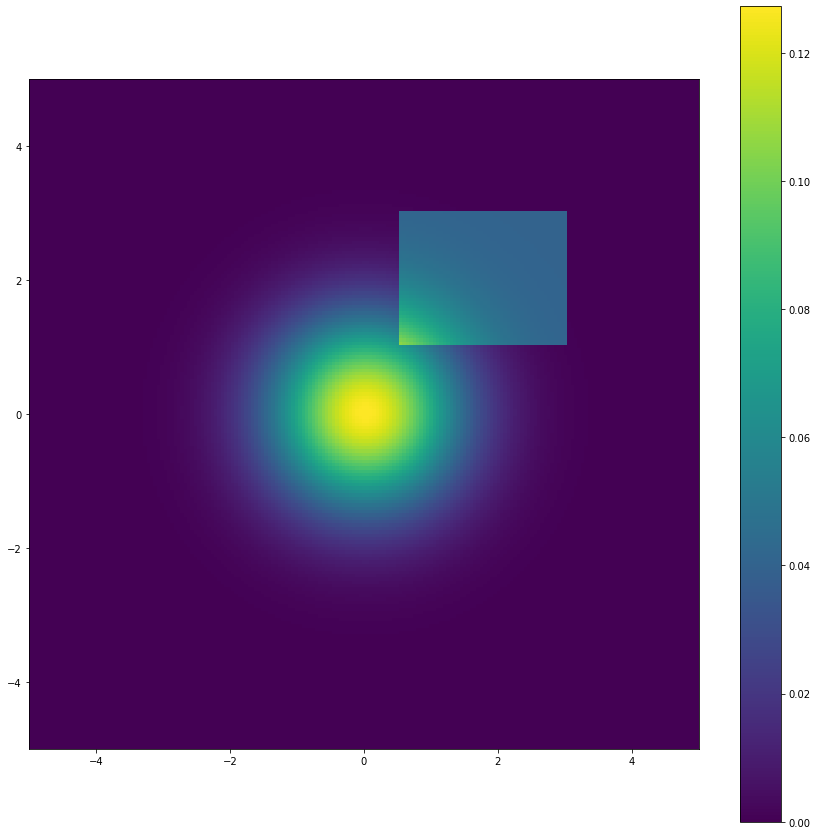

In [8]:
# Plot distribution
import matplotlib.pyplot as plt

middle_point = [0,0]
range_p = [5, 5]

grid_size = 200
xx, yy = torch.meshgrid(torch.linspace((middle_point[0]-range_p[0]), (middle_point[0]+range_p[0]), grid_size), torch.linspace((middle_point[1]-range_p[1]), (middle_point[1]+range_p[1]), grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)

prob = calculate_pdf(zz, prob_delta = prob_delta)[:, None].reshape(200, 200)

plt.figure(figsize=(15, 15))
c =  plt.pcolormesh(xx, yy, prob)
plt.colorbar(c)
plt.gca().set_aspect('equal', 'box')
plt.show()

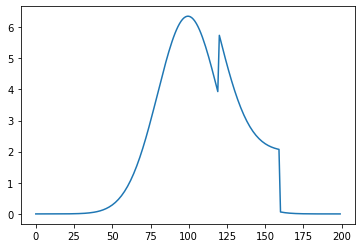

In [9]:
plt.plot(np.sum(prob.numpy(), axis =0))

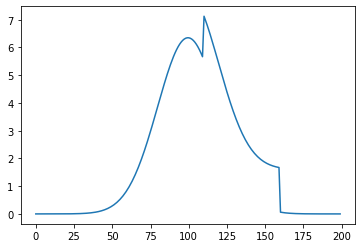

In [10]:
plt.plot(np.sum(prob.numpy(), axis = 1))

In [11]:
class MyDistribution(nn.Module):

    def __init__(self):
        super().__init__()
    
    def forward(self, num_samples):
        """Sample from distribution and calculate log prob"""
        raise NotImplementedError
    
    def log_prob(self, z):
        """Calculate log prob for batch"""
        raise NotImplementedError


class NormUnif(MyDistribution):
    def __init__(self, x_dim, prob_delta, K_intervals):
        super().__init__()

        self.x_dim = x_dim
        self.prob_delta = prob_delta
        self.K_intervals = K_intervals

        self.m = torch.distributions.MultivariateNormal(torch.zeros(self.x_dim), torch.eye(self.x_dim))

    def calculate_pdf(self, sample_point):
        K_area = torch.prod(torch.diff(self.K_intervals, dim = 0))

        if len(sample_point.shape) == 1:
            is_in_area = torch.sum(
                torch.logical_and(
                    torch.gt(sample_point, self.K_intervals[0]),
                    torch.lt(sample_point, self.K_intervals[1])
                    )
                )
            return self.prob_delta * np.exp(m.log_prob(sample_point)) + (1 - self.prob_delta) * (1 / K_area) * is_in_area

        elif len(sample_point.shape) == 2:
            is_in_area = \
            torch.eq( 
            torch.sum(torch.logical_and(
                torch.gt(sample_point, self.K_intervals[0]),
                torch.lt(sample_point, self.K_intervals[1])), dim = 1), 
            sample_point.shape[1] * torch.ones((sample_point.shape[0],)))

            return self.prob_delta * np.exp(self.m.log_prob(sample_point)) + (1 - self.prob_delta) * (1 / K_area) * is_in_area

    def log_prob(self, z):
        return torch.log(self.calculate_pdf(z))


    def forward(self, num_samples=1):
        # Sample from X
        # 1) Sample delta
        delta = torch.bernoulli(torch.ones((num_samples, 1))*self.prob_delta)

        # 2) Sample from Z
        
        Z = self.m.sample((num_samples,))

        # 3) Sample from K
        K = torch.rand(num_samples, self.x_dim)


        #1st row
        K_start = K_intervals[0][None, :] # dimension expanded

        # start minus end
        K_range = torch.diff(K_intervals, dim = 0)

        #K times range plus starting points
        K = K *  K_range + K_start

        # 4) Take X

        X = delta * Z   + (1 - delta) * K
        return  X, self.log_prob(X)


## Create a model - with one affine coupling block

In [103]:
class Swap(nn.Module):
    """
    Permutation features along the channel dimension
    """

    def __init__(self, num_channels=2):
        
        super().__init__()
        
        self.num_channels = num_channels

    def forward(self, z):
        z1 = z[:, : self.num_channels // 2, ...]
        z2 = z[:, self.num_channels // 2 :, ...]
        z = torch.cat([z2, z1], dim=1)
        log_det = 0
        return z, log_det

    def inverse(self, z):
        z1 = z[:, : (self.num_channels + 1) // 2, ...]
        z2 = z[:, (self.num_channels + 1) // 2 :, ...]
        z = torch.cat([z2, z1], dim=1)
        log_det = 0
        return z, log_det

In [1]:
#2D data

def Split(z):
    return z[:,0][:, None], z[:,1][:, None]
def Con(y1, y2):
    return torch.cat((y1, y2), 1)

def zero_log_det_like_z(z):
    return torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)

class AffineSingleBlock(nn.Module):
    def __init__(self, param_net = None):
        super().__init__()

        #self.a = torch.tensor([[1]])
        self.param_net = param_net
        
        if param_net:
            self.param_net = param_net
        else:
            self.a = torch.nn.Parameter(torch.tensor(0.0))
    
    def forward(self, z):
        x1, x2 = Split(z)
        if self.param_net:
            x1_modified = self.param_net(x1)
        else:
            x1_modified = self.a * x1
        y1 = x1
        y2 = x2 + x1_modified
        log_det = zero_log_det_like_z(y1)
        return Con(y1, y2), log_det

    def inverse(self, z):
        y1, y2 = Split(z)
        if self.param_net:
            y1_modified = self.param_net(y1)
        else:
            y1_modified = self.a * y1
        x1 = y1
        x2 = y2 - y1_modified
        log_det = zero_log_det_like_z(y1)
        return Con(x1, x2), log_det


class AffineMultipleBlocks(nn.Module):
    def __init__(self, num_affine_blocks=3):
        super().__init__()

        self.flows = nn.ModuleList([])
        for i in range(num_affine_blocks):
            self.flows += [AffineSingleBlock()]

    def forward(self, z):
        log_det_total = zero_log_det_like_z(z)
        for flow in self.flows:
            z, log_det = flow(z)
            log_det_total += log_det
        return z, log_det_total
    
    def inverse(self, z):
        log_det_total = zero_log_det_like_z(z)
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_det_total += log_det
        return z, log_det_total

NameError: name 'nn' is not defined

In [132]:
class MyNormFlow(nn.Module):
    def __init__(self, q0, flows):
        super().__init__()
        self.q0 =  q0
        self.flows = nn.ModuleList(flows)

    def forward_kld(self, x):
        """Estimates forward KL divergence, see [arXiv 1912.02762](https://arxiv.org/abs/1912.02762)
        Args:
          x: Batch sampled from target distribution
        Returns:
          Estimate of forward KL divergence averaged over batch
        """
        log_q = torch.zeros(len(x), device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.q0.log_prob(z)
        return -torch.mean(log_q)

    
    def sample(self, num_samples):
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q

    def log_prob(self, x):
        log_q = torch.zeros(x.shape[0], dtype=x.dtype, device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.q0.log_prob(z)
        return log_q


## Experiments

### Creating model

In [133]:
base = nf.distributions.base.DiagGaussian(2)
flows = [AffineMultipleBlocks(num_affine_blocks=1)]
flows += [Swap()]
flows += [AffineMultipleBlocks(num_affine_blocks=1)]
flows += [Swap()]

model = MyNormFlow(q0 = base, flows = flows)

In [134]:
# Target distribution:

K_intervals = torch.Tensor([[0.5, 1],
                        [3,3]])
prob_delta = 0.1

nu = NormUnif(x_dim = 2, prob_delta=prob_delta, K_intervals=K_intervals)

### Target distribution

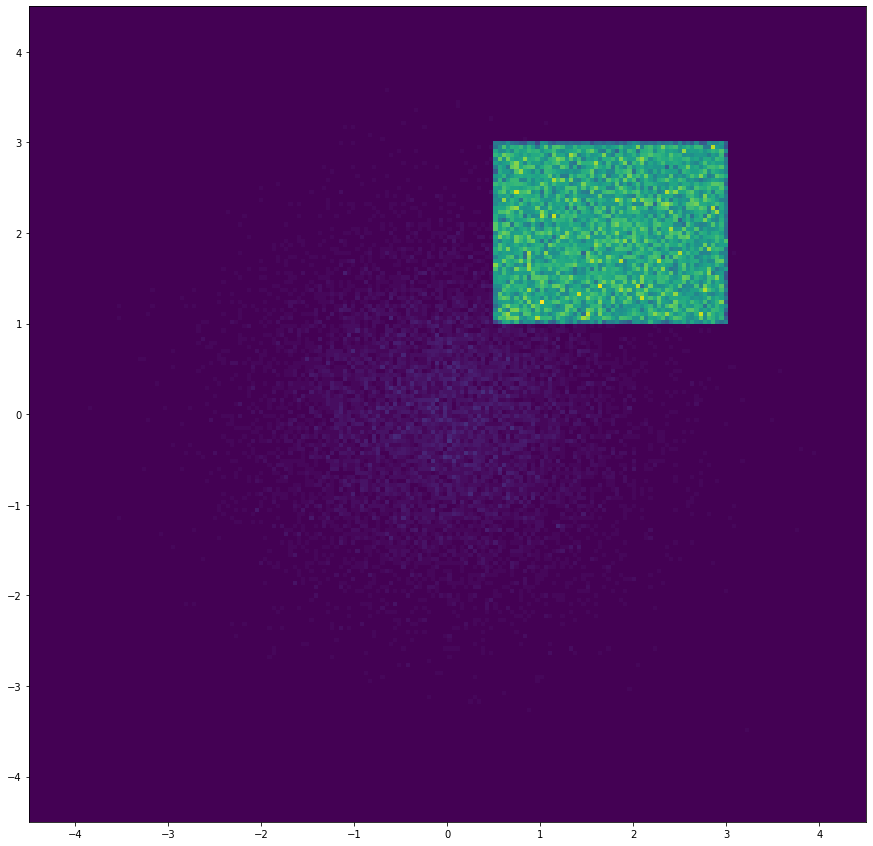

In [135]:
x_np = nu.forward(100000)[0].numpy()
plt.figure(figsize=(15, 15))
plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200, range=[[-4.5, 4.5], [-4.5, 4.5]])
plt.show()

<ipython-input-136-7c27199faf13>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())


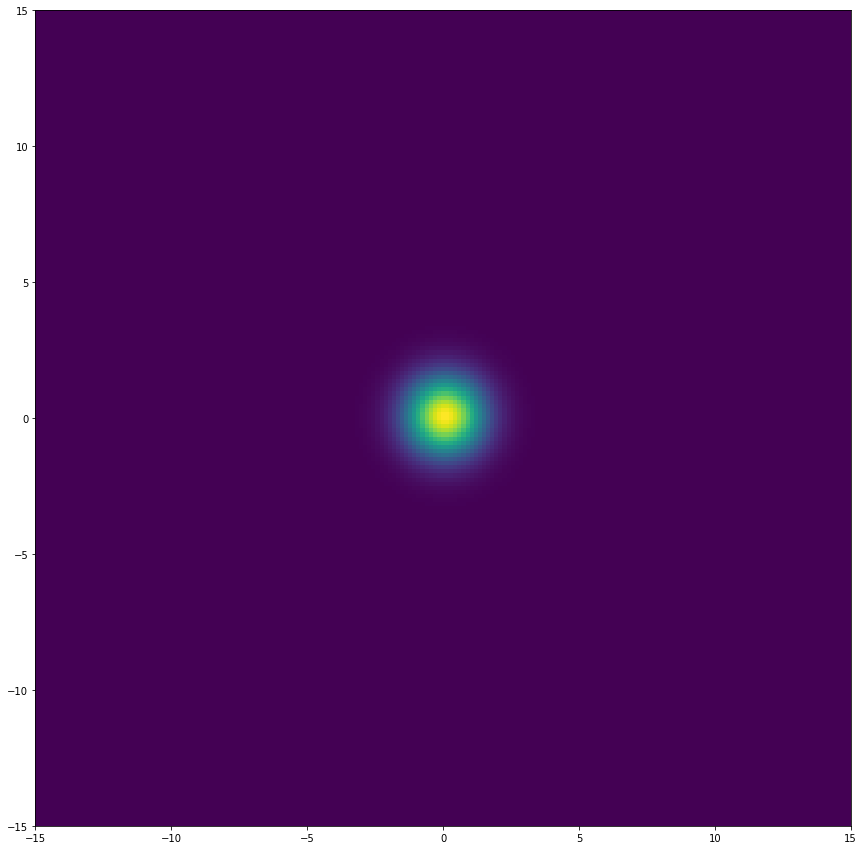

In [136]:
# Plot BASE distribution for comparison
grid_size = 200
#xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
xx, yy = torch.meshgrid(torch.linspace(-15, 15, grid_size), torch.linspace(-15, 15, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)


model.eval()
log_prob = base.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

In [137]:
# Plot initial flow distribution
grid_size = 200
#xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
xx, yy = torch.meshgrid(torch.linspace(-15, 15, grid_size), torch.linspace(-15, 15, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)


model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

AttributeError: 'AffineSingleBlock' object has no attribute 'param_net'

<ipython-input-138-099aacdca21b>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c =  plt.pcolormesh(xx, yy, prob)


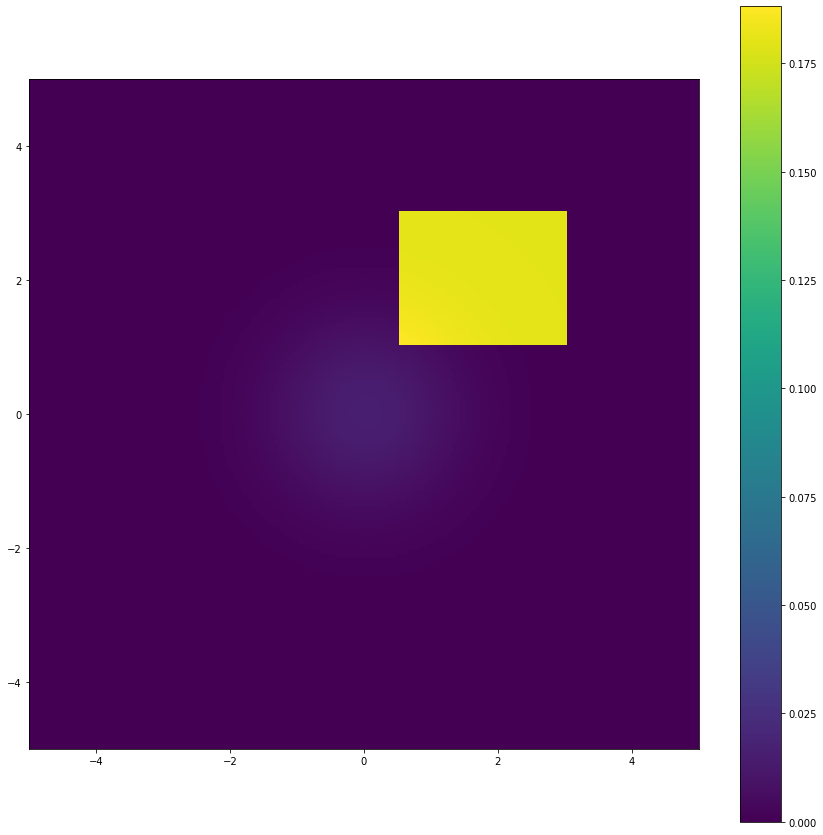

In [138]:
# Plot distribution
import matplotlib.pyplot as plt

middle_point = [0,0]
range_p = [5, 5]

grid_size = 200
xx, yy = torch.meshgrid(torch.linspace((middle_point[0]-range_p[0]), (middle_point[0]+range_p[0]), grid_size), torch.linspace((middle_point[1]-range_p[1]), (middle_point[1]+range_p[1]), grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)

prob = calculate_pdf(zz, prob_delta = prob_delta)[:, None].reshape(200, 200)

plt.figure(figsize=(15, 15))
c =  plt.pcolormesh(xx, yy, prob)
plt.colorbar(c)
plt.gca().set_aspect('equal', 'box')
plt.show()

In [139]:
# Train model
max_iter = 4000
num_samples = 100000
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    x_np = nu.forward(num_samples)[0].numpy()
    x = torch.tensor(x_np).float()
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned posterior
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

  0%|          | 0/4000 [00:00<?, ?it/s]


AttributeError: 'AffineSingleBlock' object has no attribute 'param_net'

### Experiment with 40 000 iterations

  1%|          | 498/40000 [00:18<24:13, 27.17it/s]<ipython-input-128-ca0b7cd74fbb>:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())


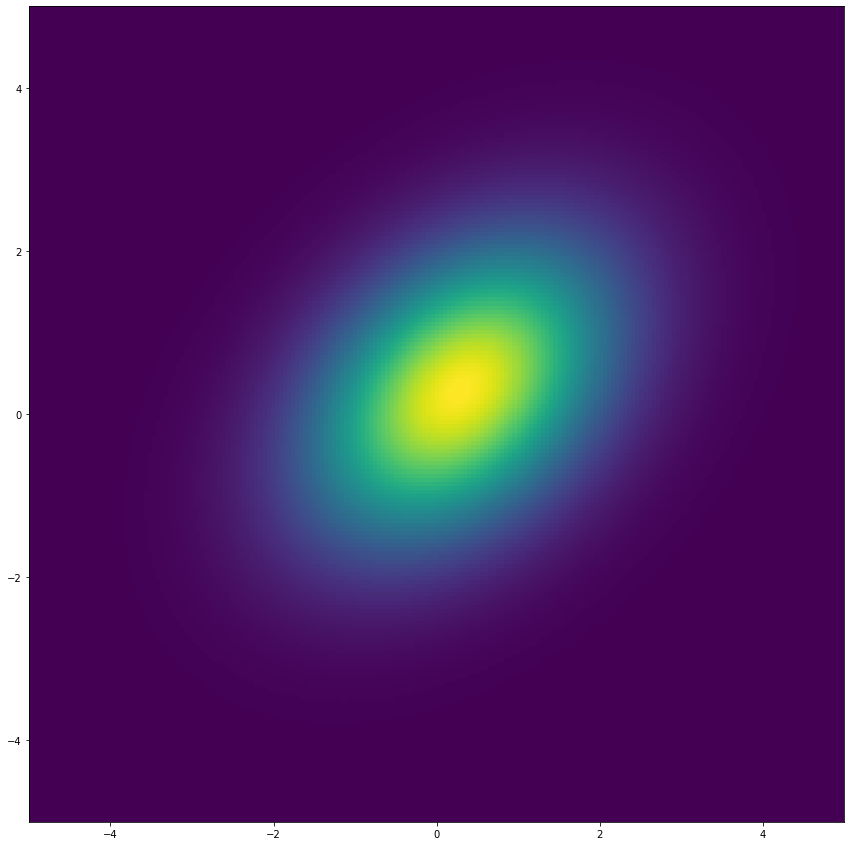

  2%|▏         | 998/40000 [00:36<20:54, 31.10it/s]

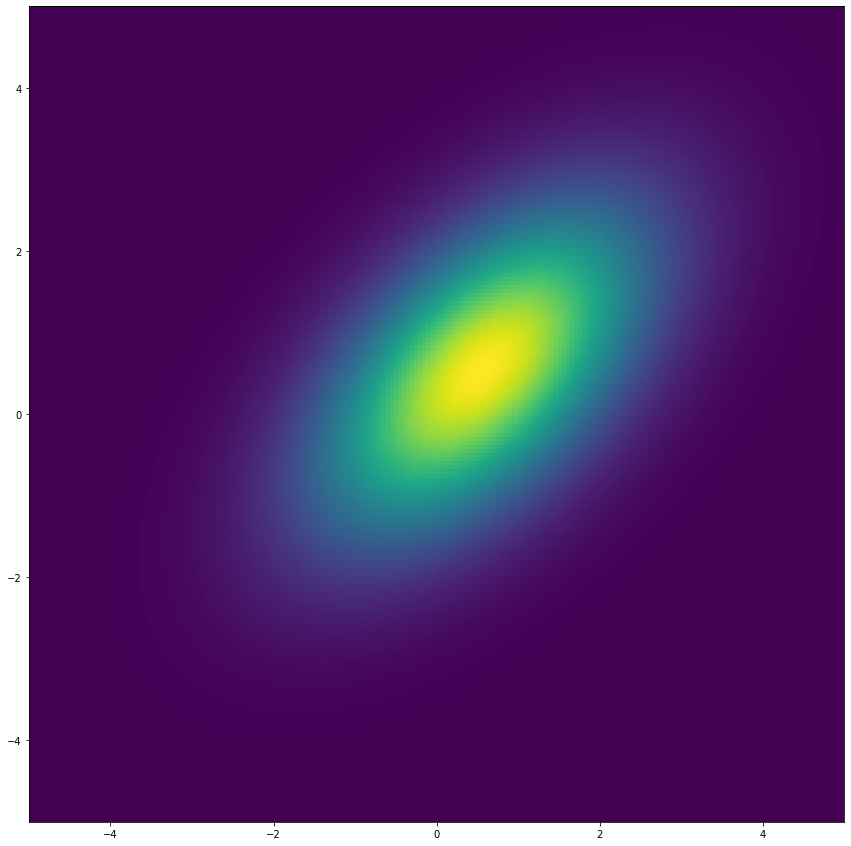

  4%|▎         | 1499/40000 [00:54<20:54, 30.68it/s]

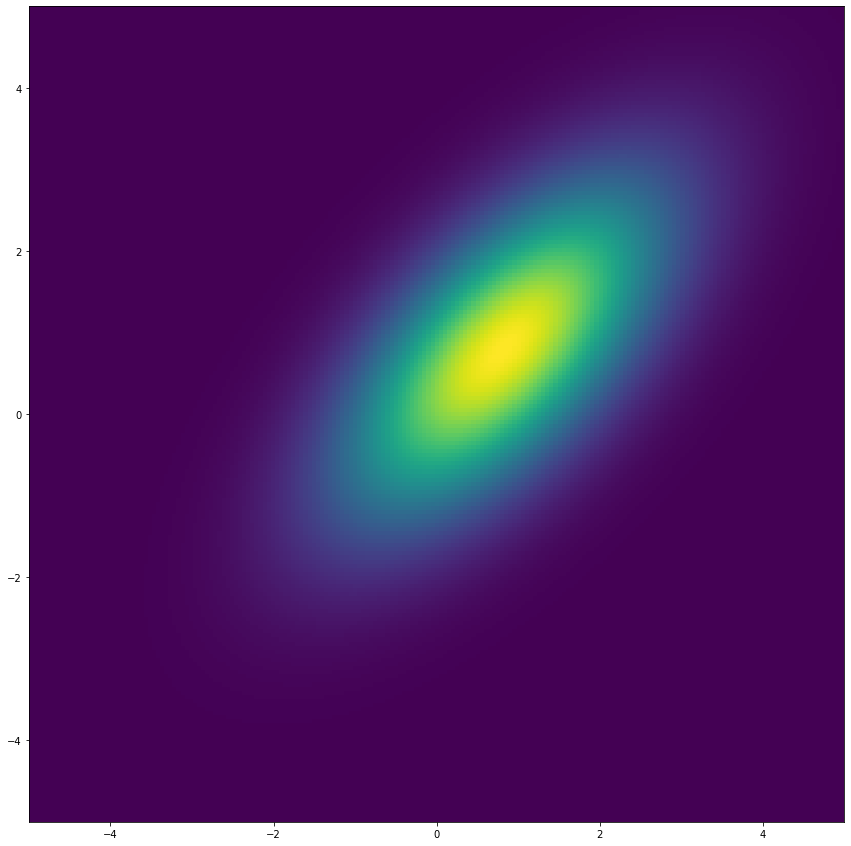

  5%|▍         | 1999/40000 [01:11<18:05, 35.00it/s]

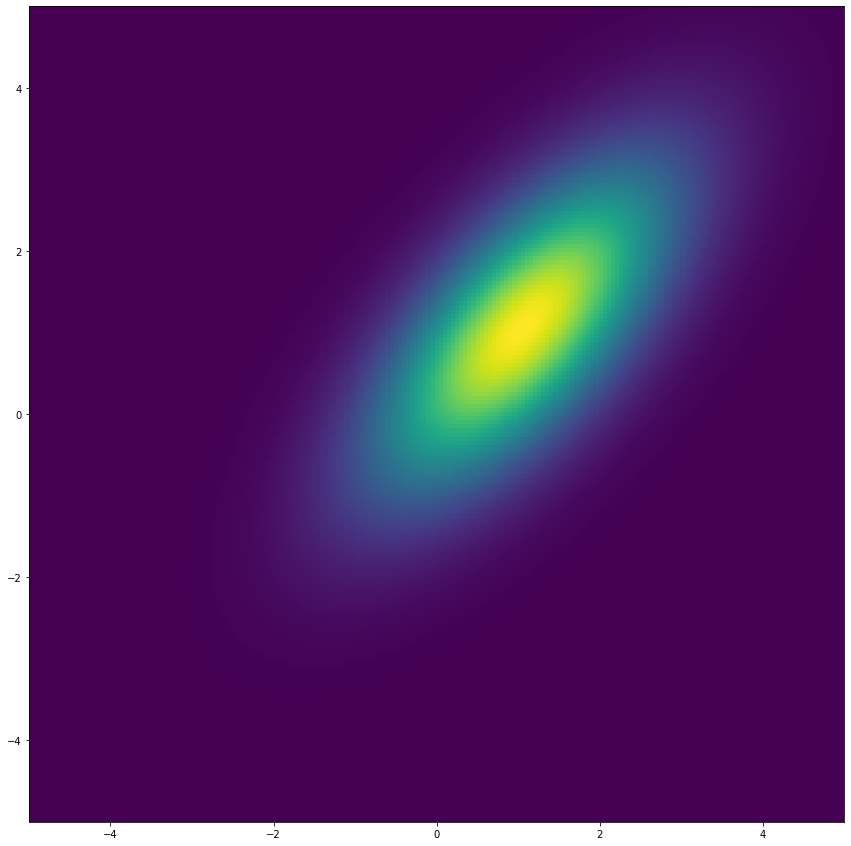

  6%|▌         | 2496/40000 [01:26<16:07, 38.76it/s]

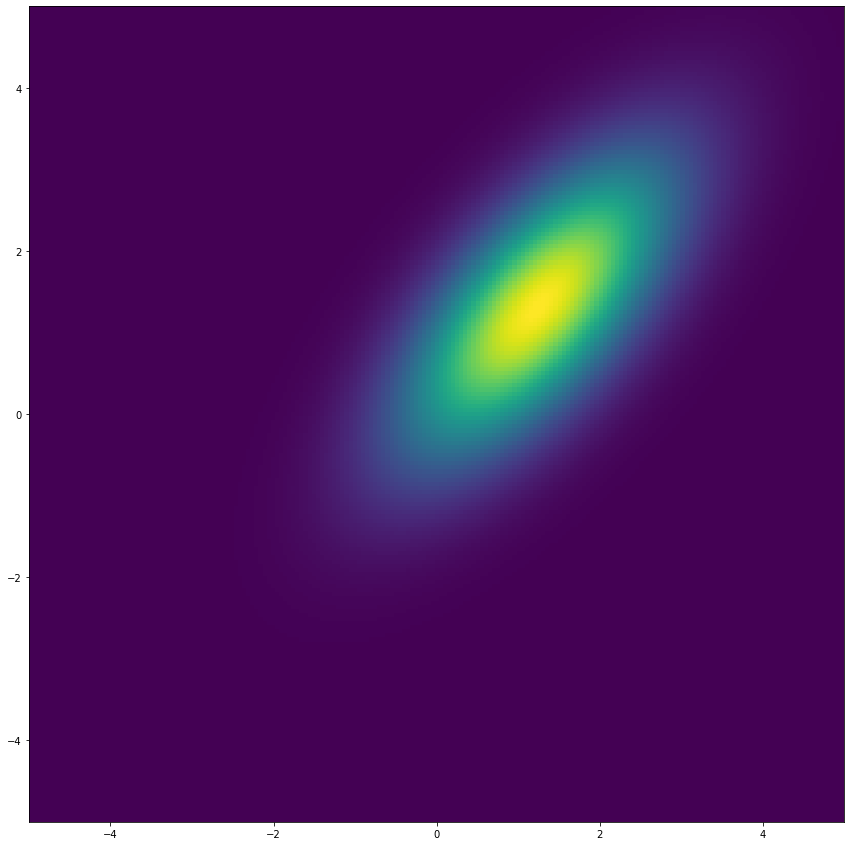

  7%|▋         | 2998/40000 [01:42<16:04, 38.37it/s]

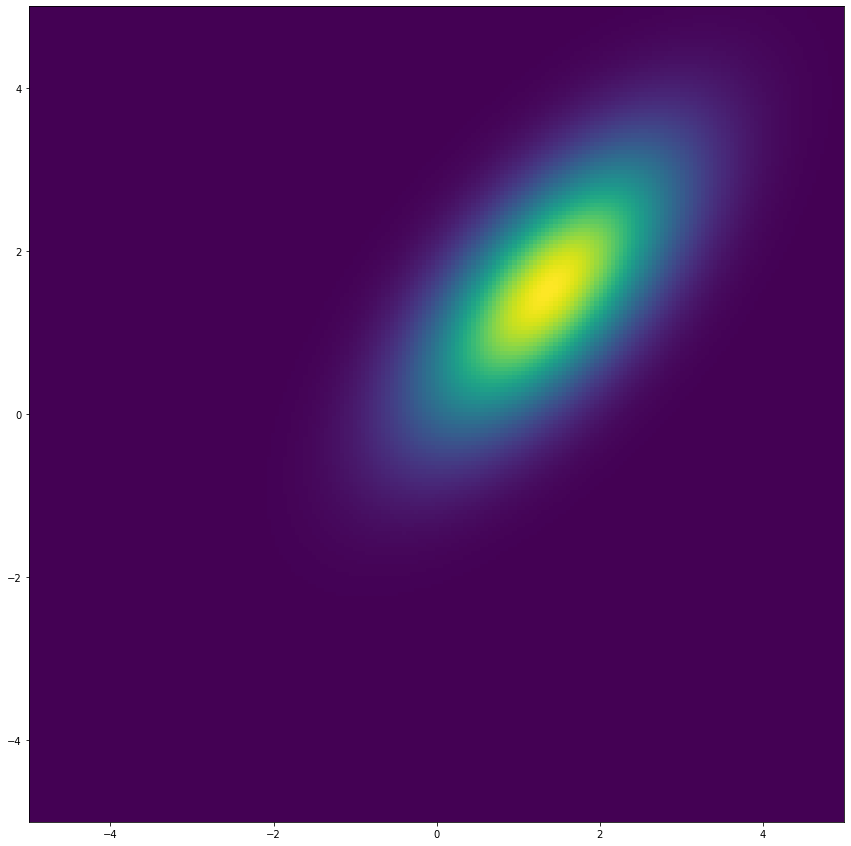

  9%|▊         | 3498/40000 [01:57<16:46, 36.28it/s]

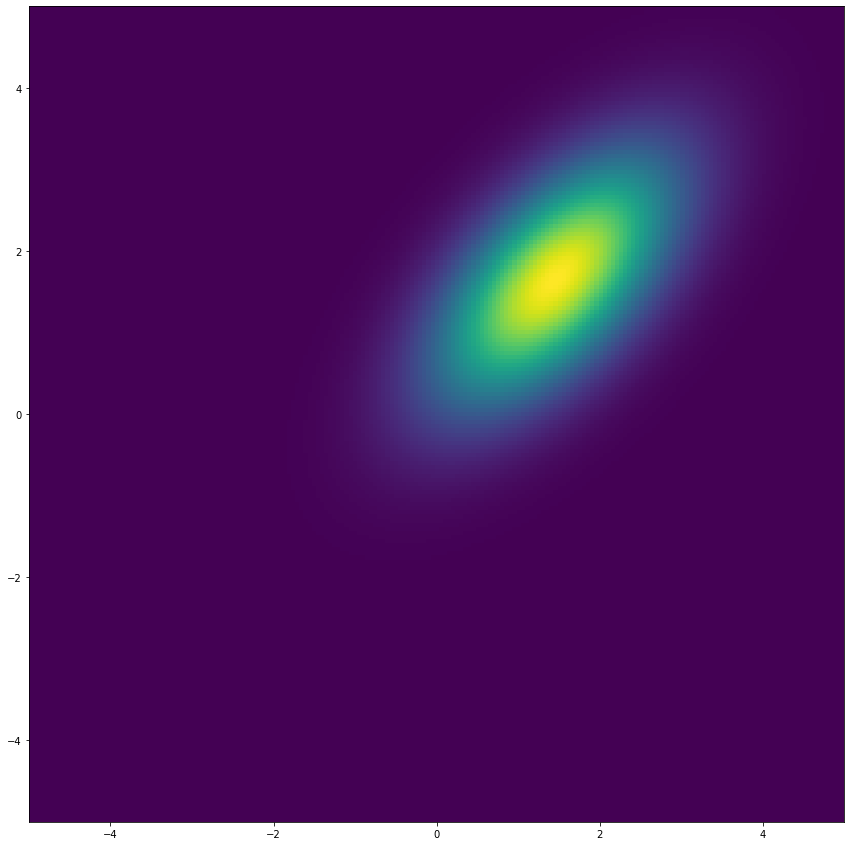

 10%|▉         | 3997/40000 [02:12<18:03, 33.24it/s]

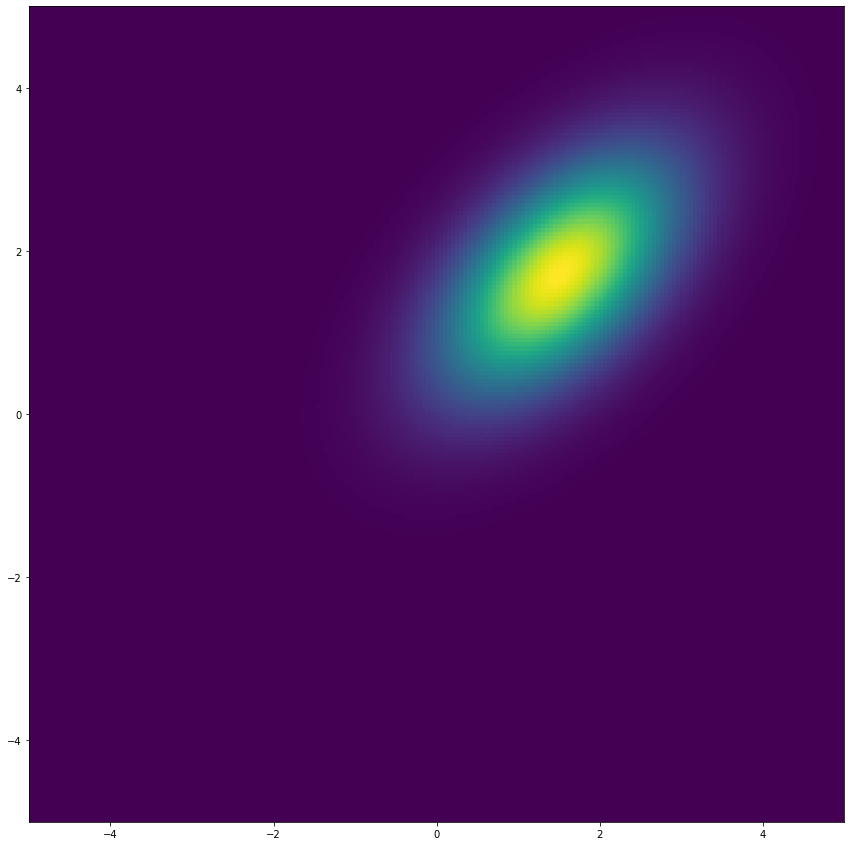

 11%|█         | 4497/40000 [02:28<18:38, 31.75it/s]

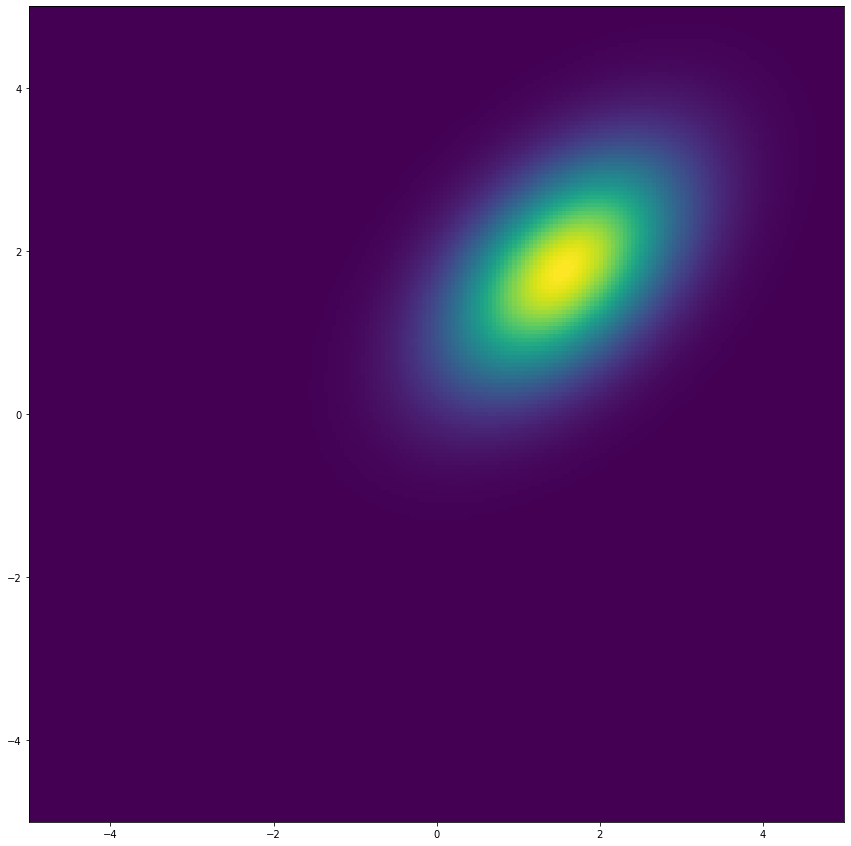

 12%|█▏        | 4996/40000 [02:43<18:03, 32.29it/s]

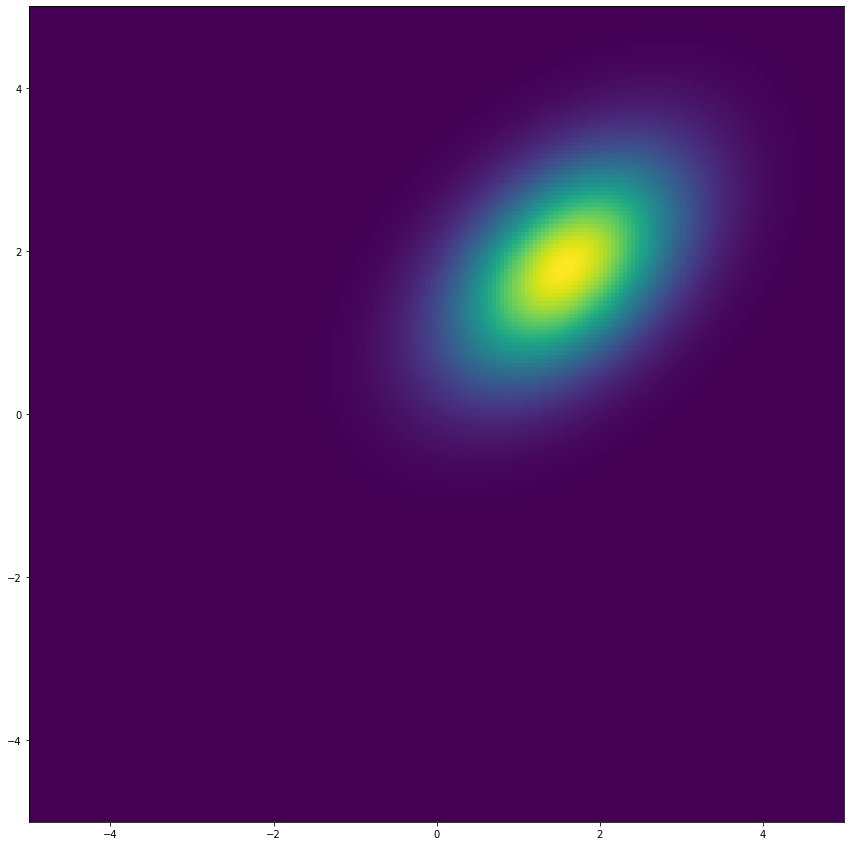

 14%|█▎        | 5497/40000 [02:58<16:57, 33.90it/s]

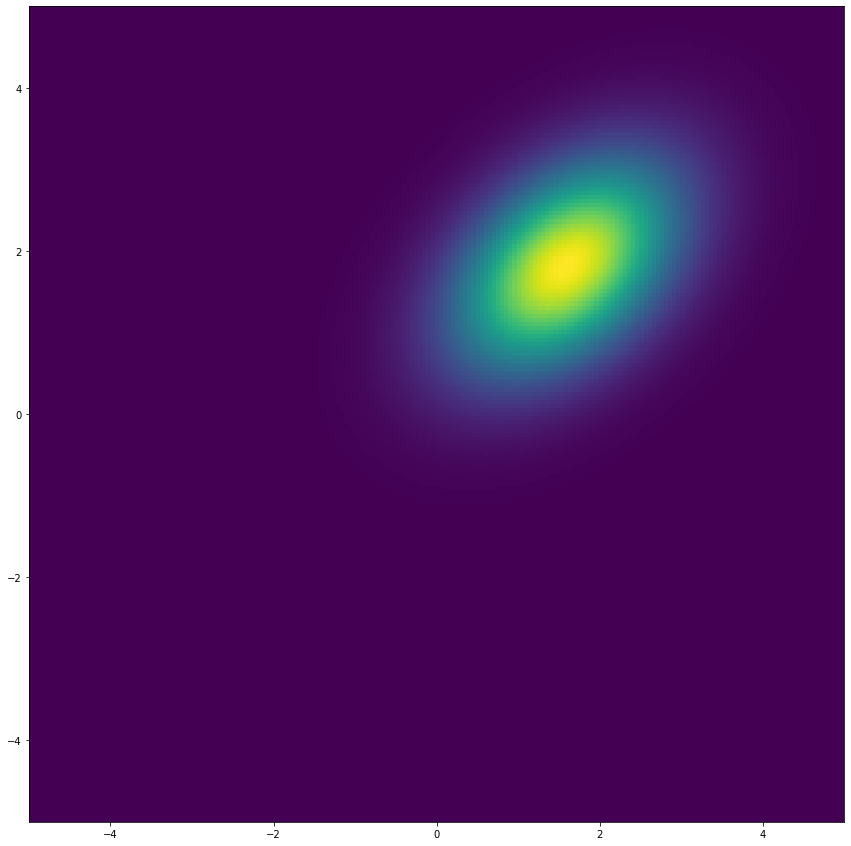

 15%|█▍        | 5999/40000 [03:13<16:46, 33.78it/s]

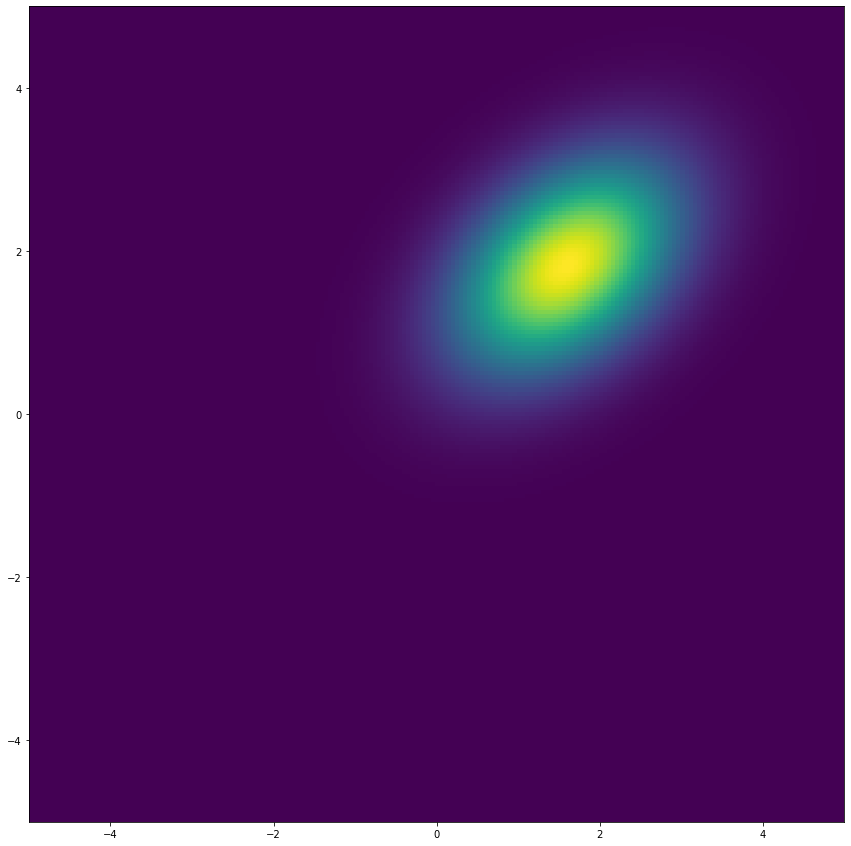

 16%|█▌        | 6497/40000 [03:34<18:44, 29.81it/s]

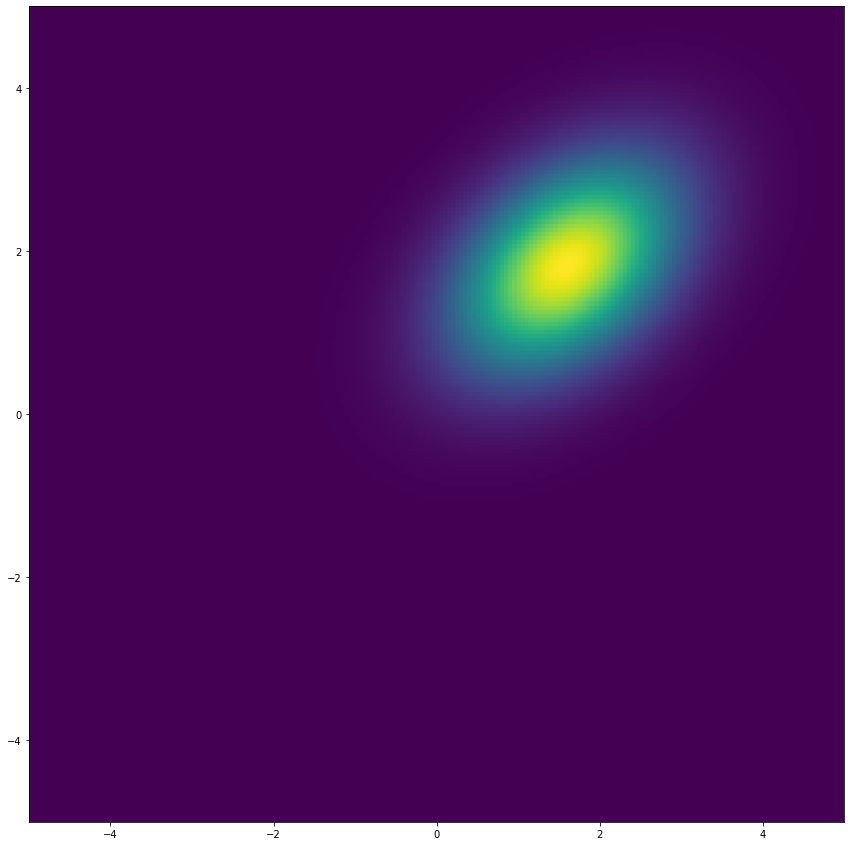

 17%|█▋        | 6997/40000 [03:50<14:35, 37.70it/s]

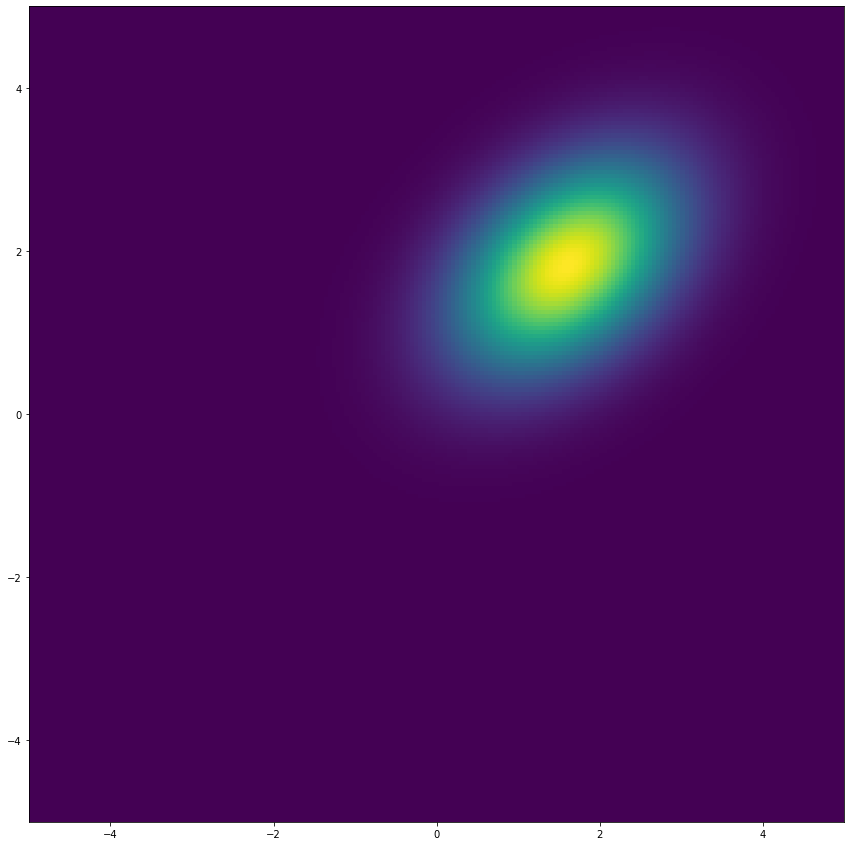

 19%|█▊        | 7497/40000 [04:06<15:45, 34.39it/s]

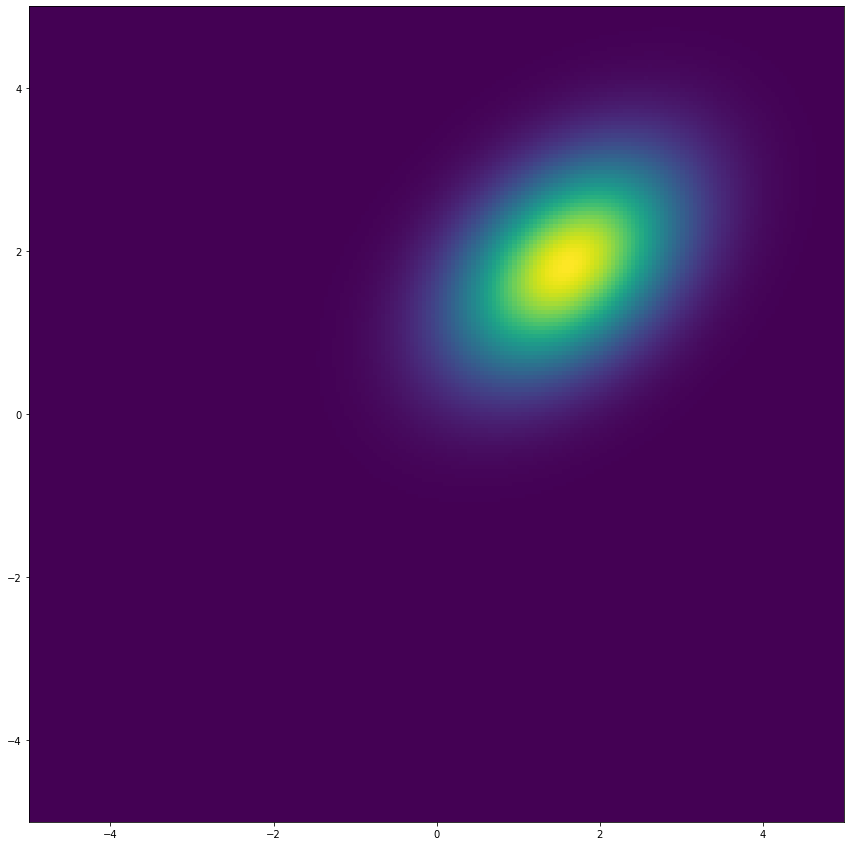

 20%|█▉        | 7999/40000 [04:22<16:51, 31.62it/s]

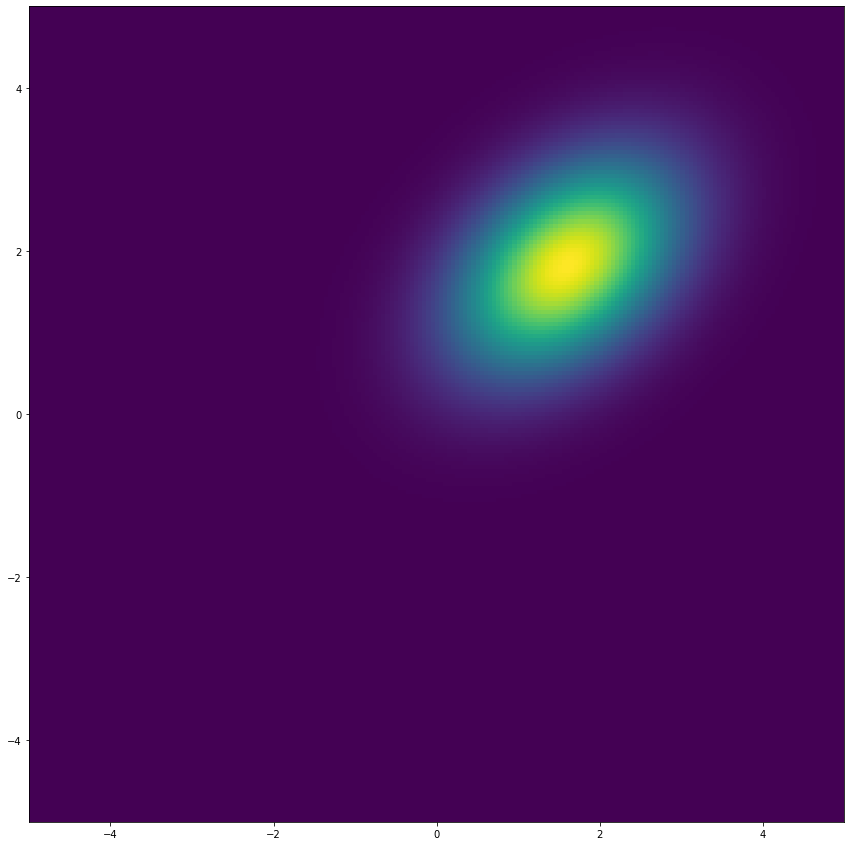

 21%|██        | 8496/40000 [04:38<15:58, 32.87it/s]

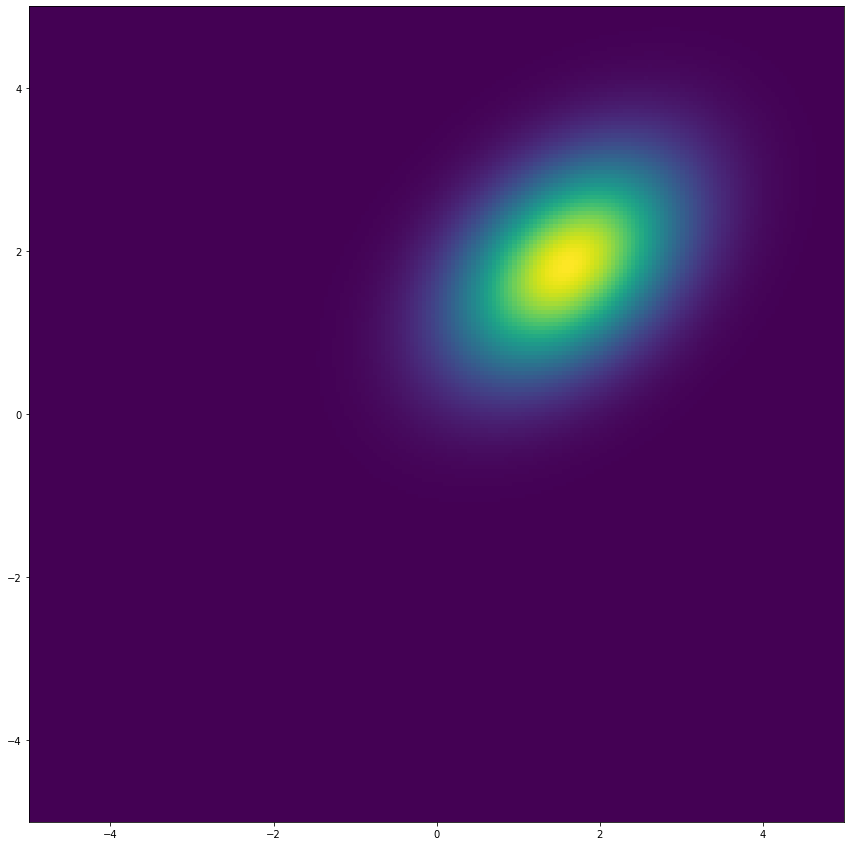

 22%|██▏       | 8996/40000 [04:53<16:56, 30.50it/s]

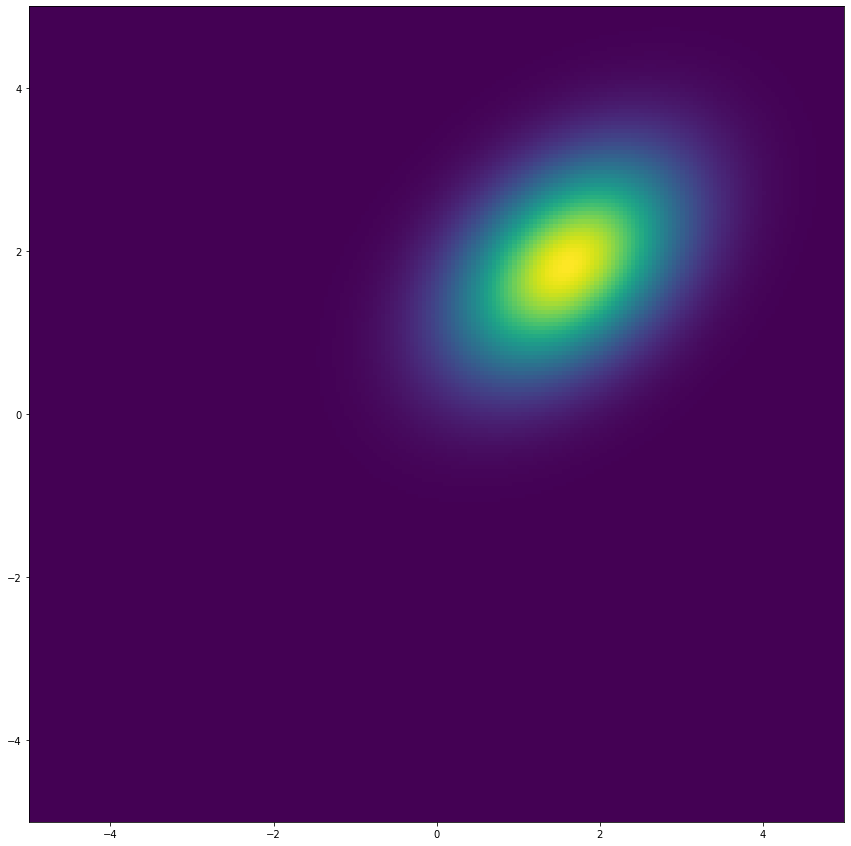

 24%|██▎       | 9496/40000 [05:11<24:10, 21.03it/s]

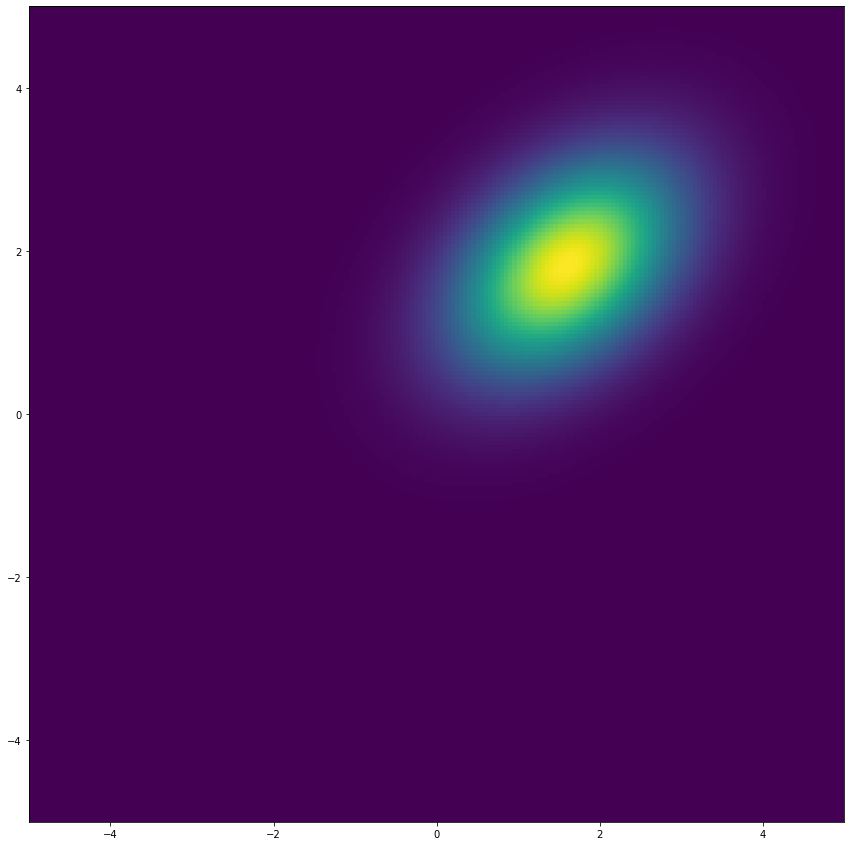

 25%|██▍       | 9997/40000 [05:28<16:00, 31.25it/s]

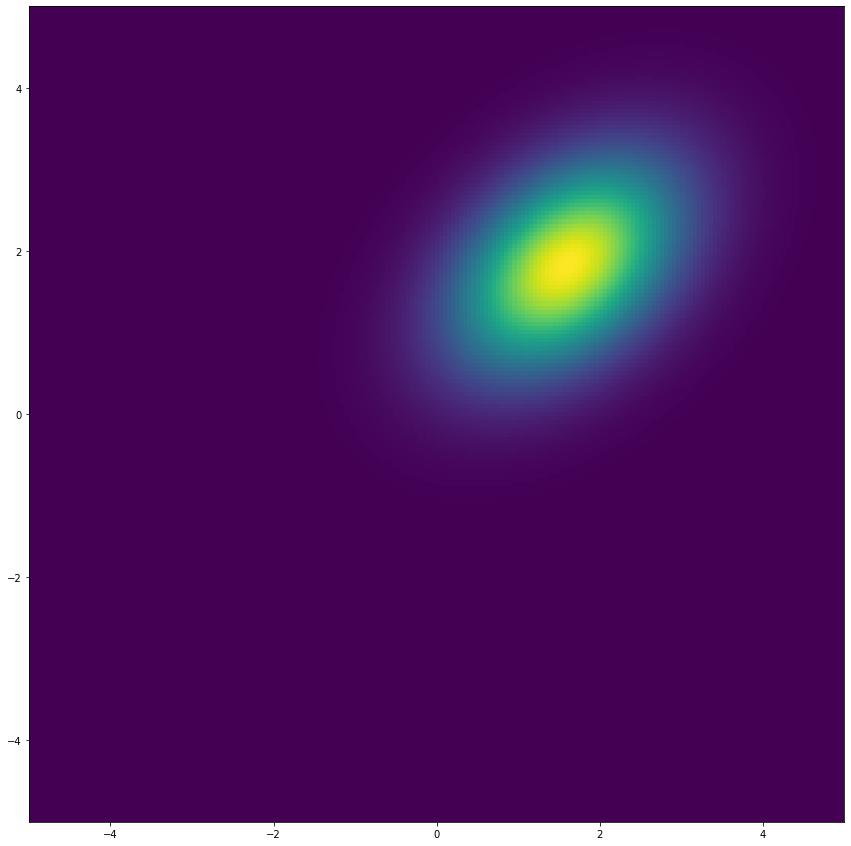

 26%|██▌       | 10497/40000 [05:45<16:41, 29.45it/s]

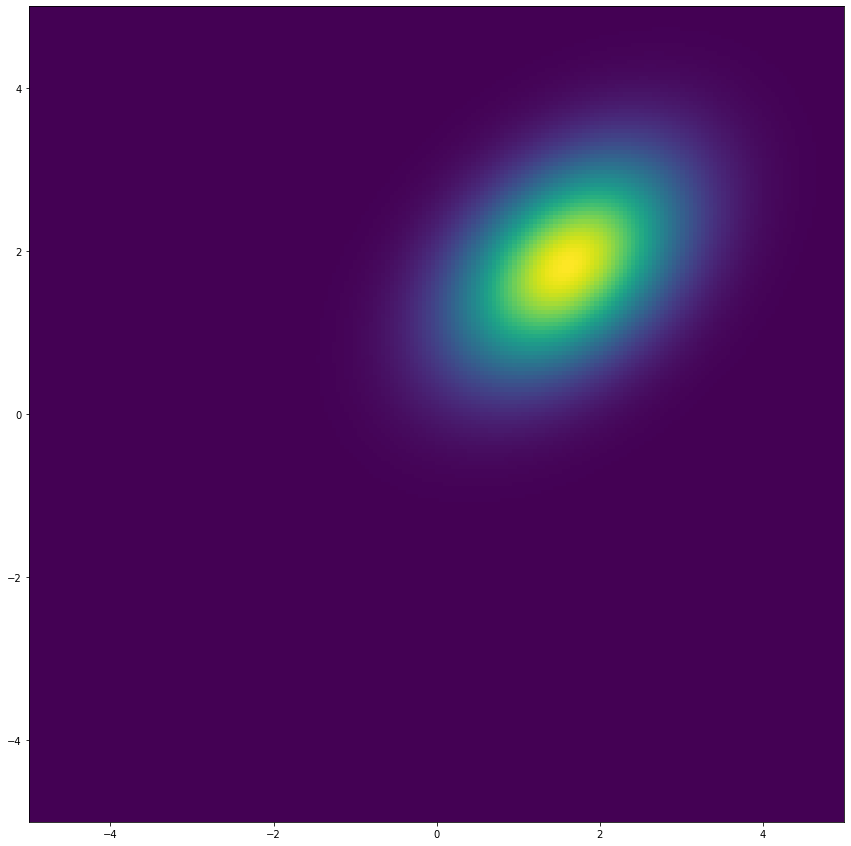

 27%|██▋       | 10996/40000 [06:03<14:39, 32.97it/s]

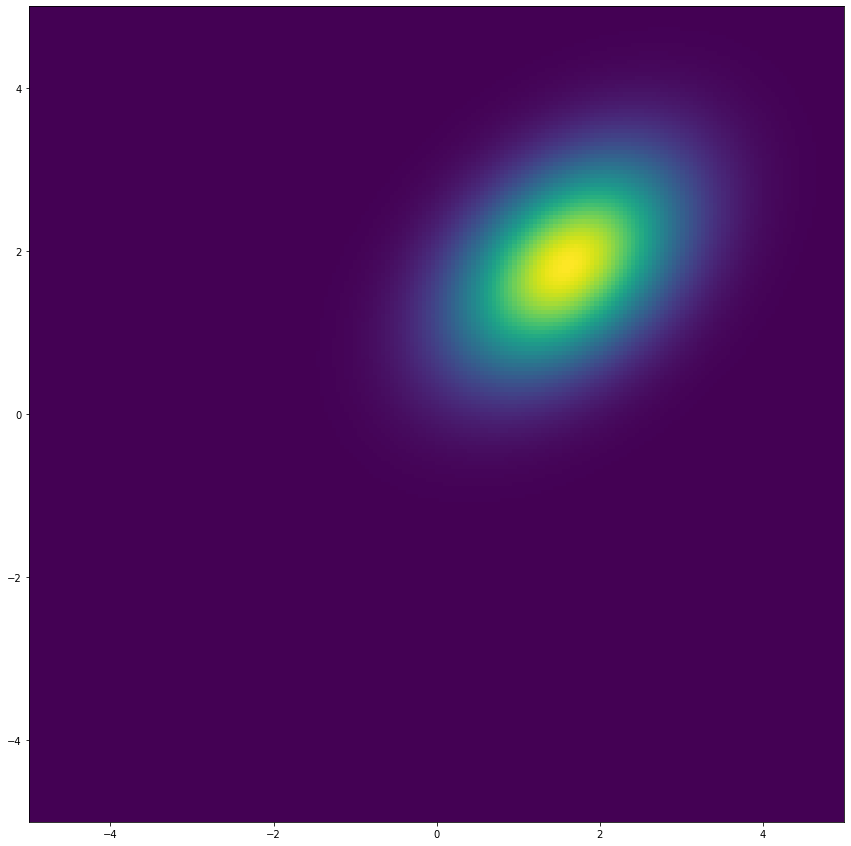

 29%|██▊       | 11499/40000 [06:19<13:19, 35.64it/s]

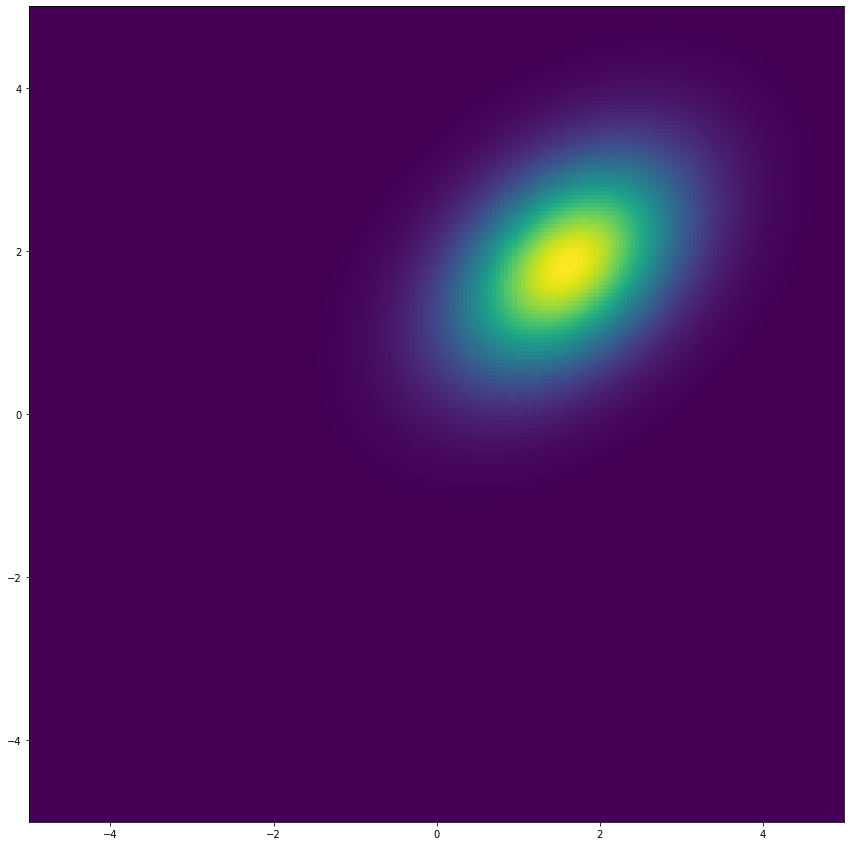

 30%|██▉       | 11999/40000 [06:35<14:18, 32.62it/s]

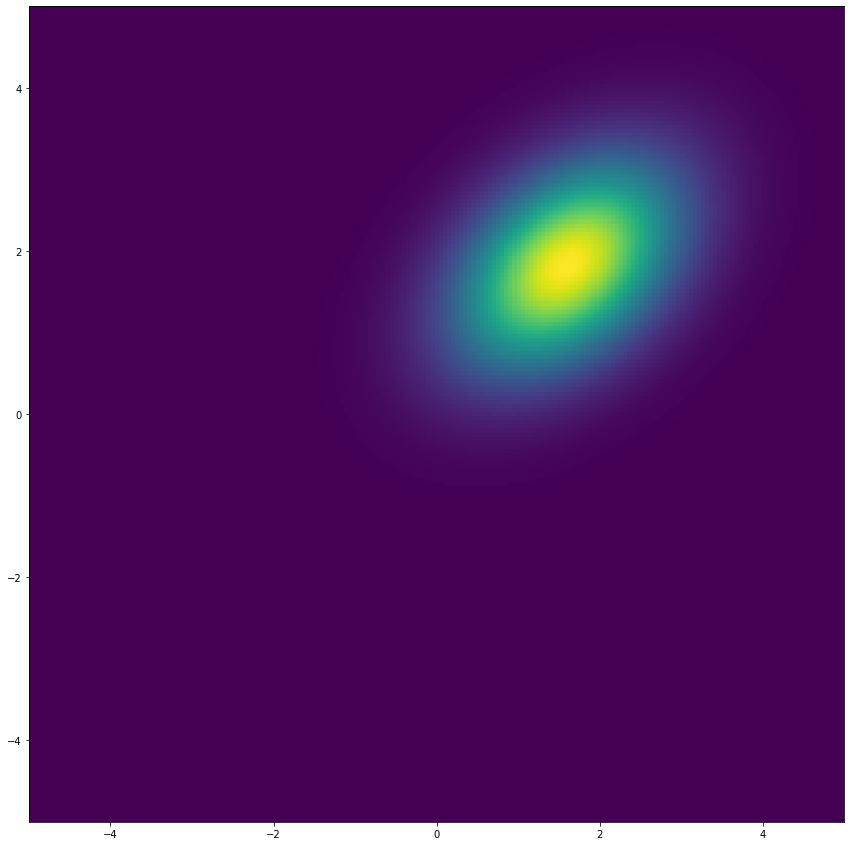

 31%|███       | 12499/40000 [06:50<13:51, 33.07it/s]

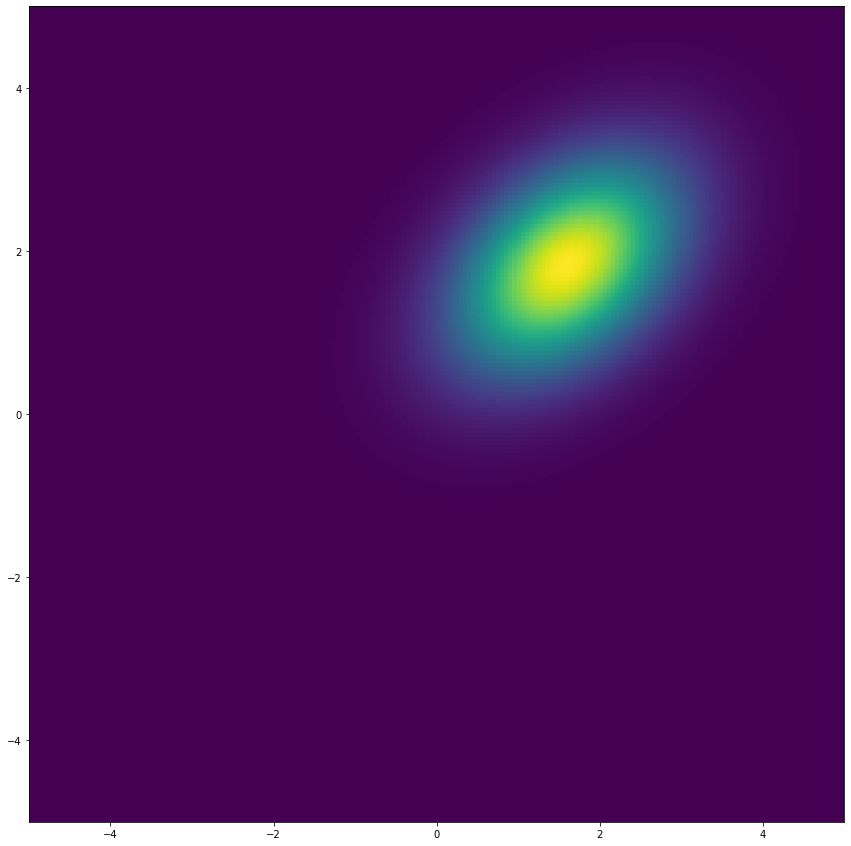

 32%|███▏      | 12997/40000 [07:08<14:01, 32.11it/s]

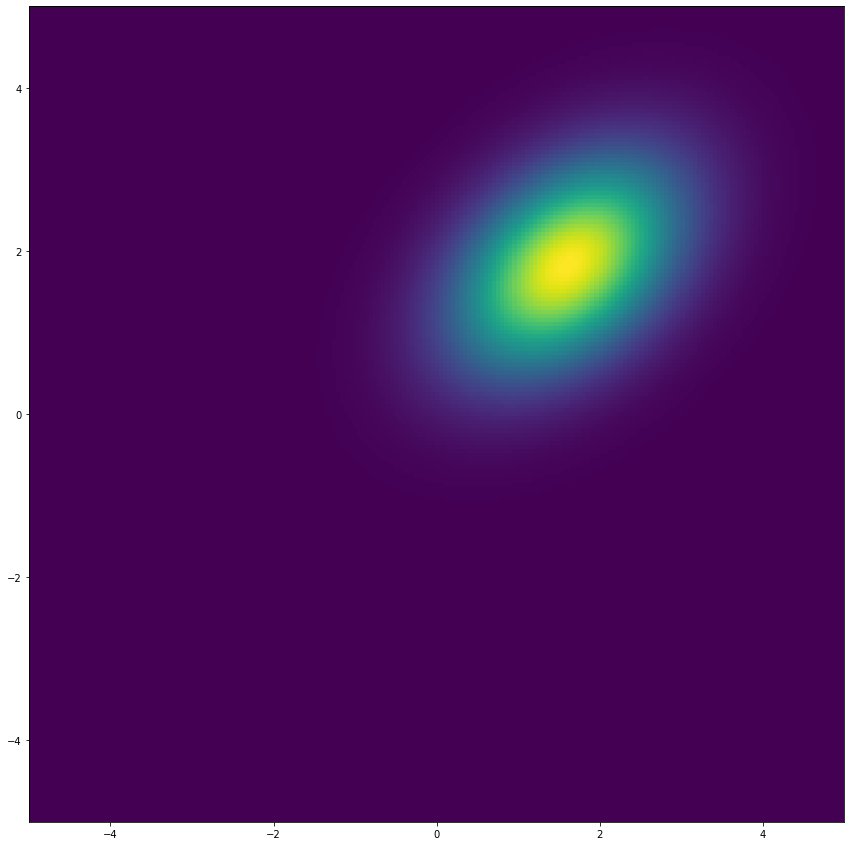

 34%|███▎      | 13498/40000 [07:28<15:33, 28.40it/s]

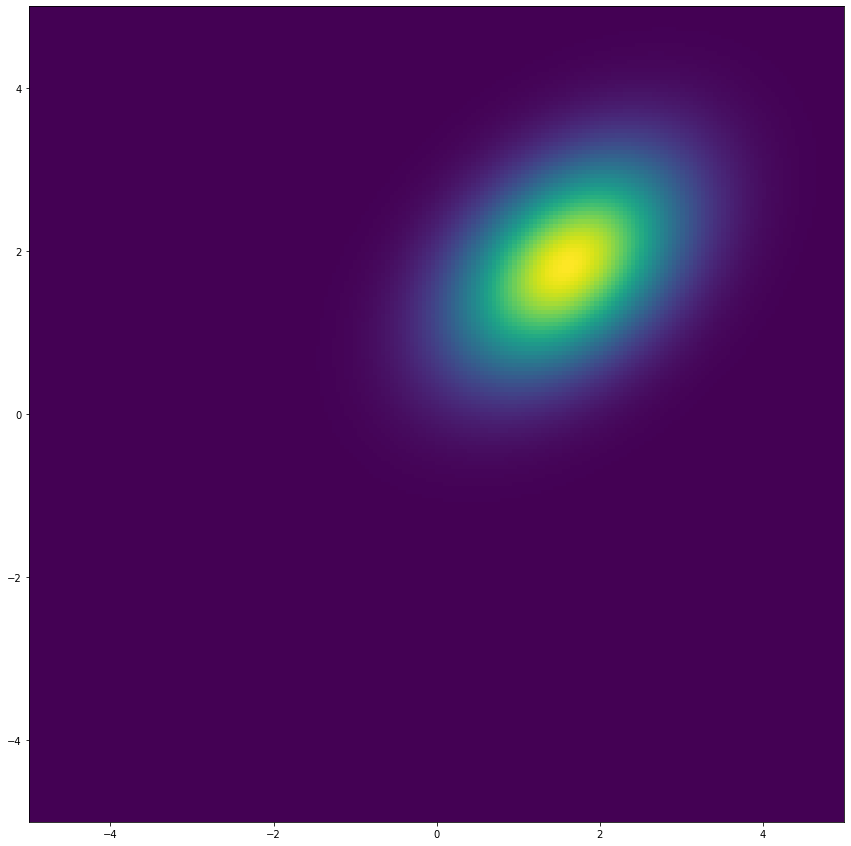

 35%|███▍      | 13997/40000 [07:44<15:12, 28.50it/s]

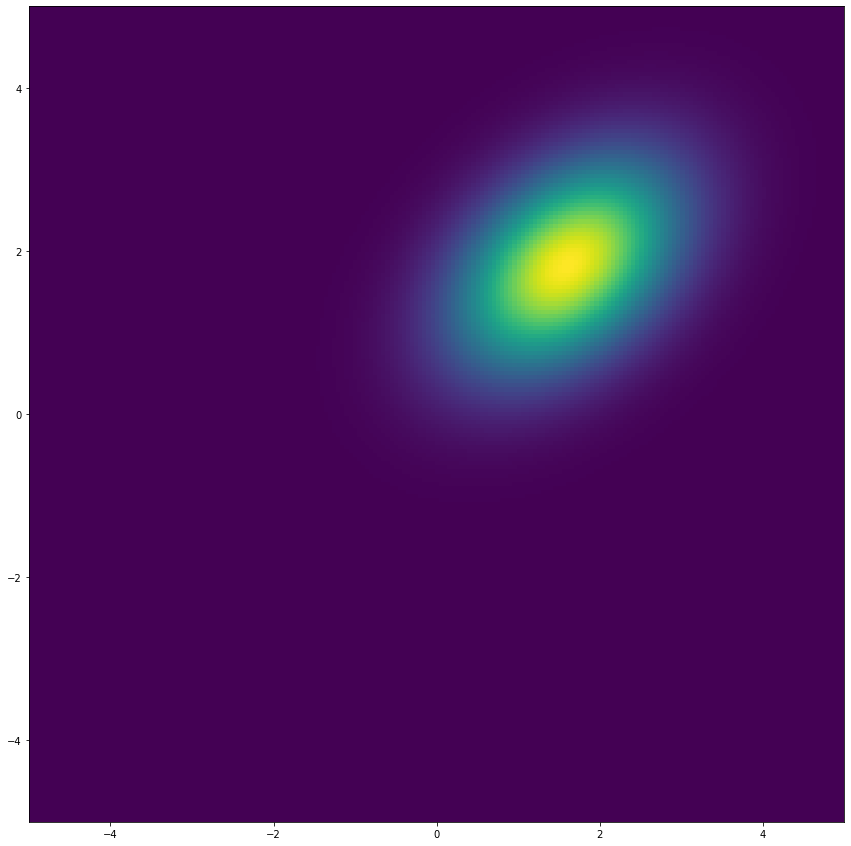

 36%|███▌      | 14499/40000 [08:01<12:52, 33.01it/s]

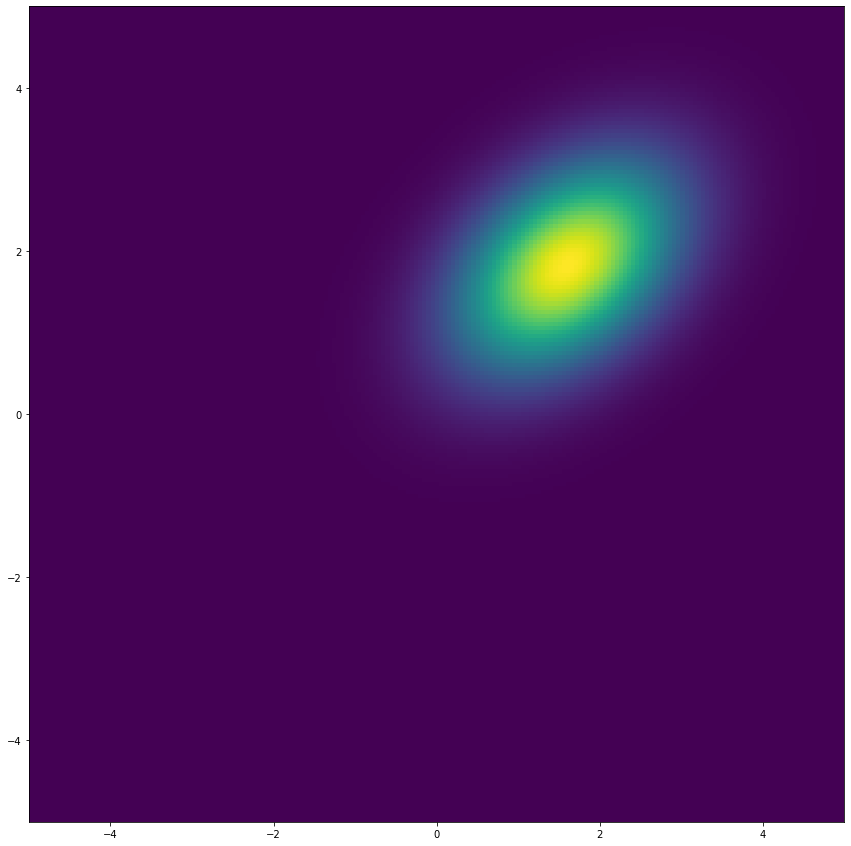

 37%|███▋      | 14997/40000 [08:18<13:55, 29.92it/s]

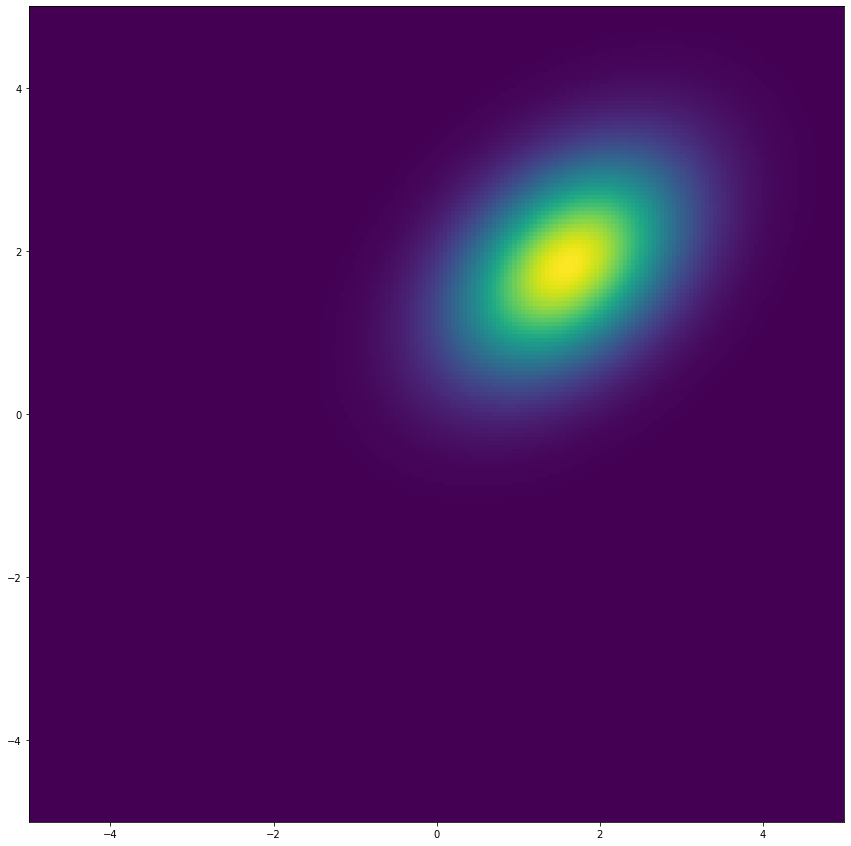

 39%|███▊      | 15499/40000 [08:34<12:51, 31.76it/s]

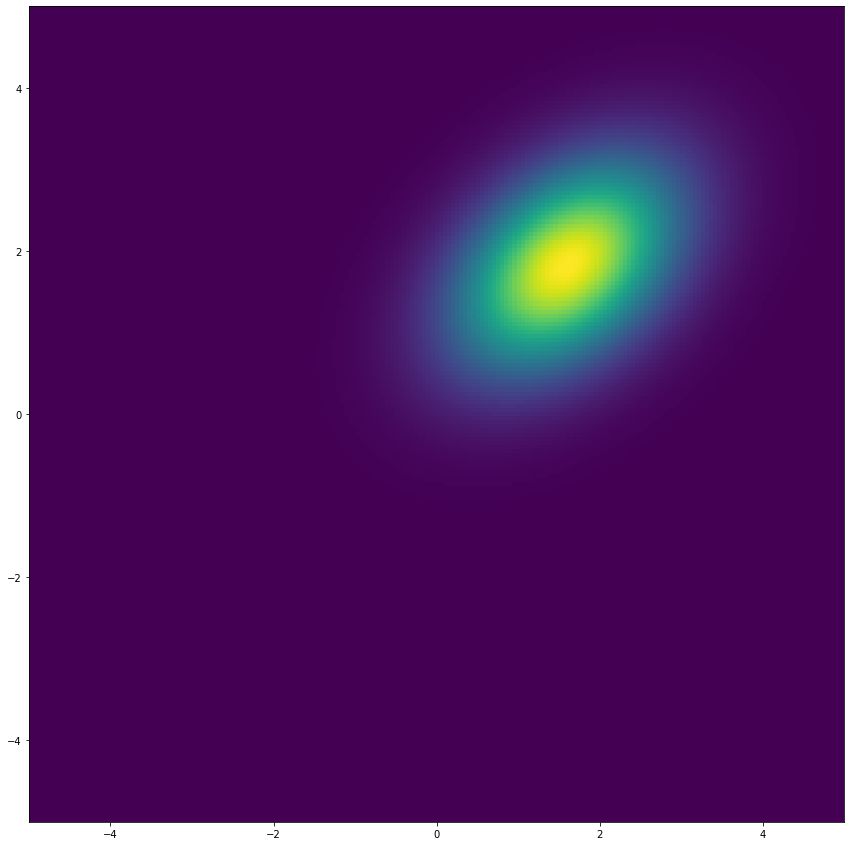

 40%|███▉      | 15996/40000 [08:53<12:23, 32.27it/s]

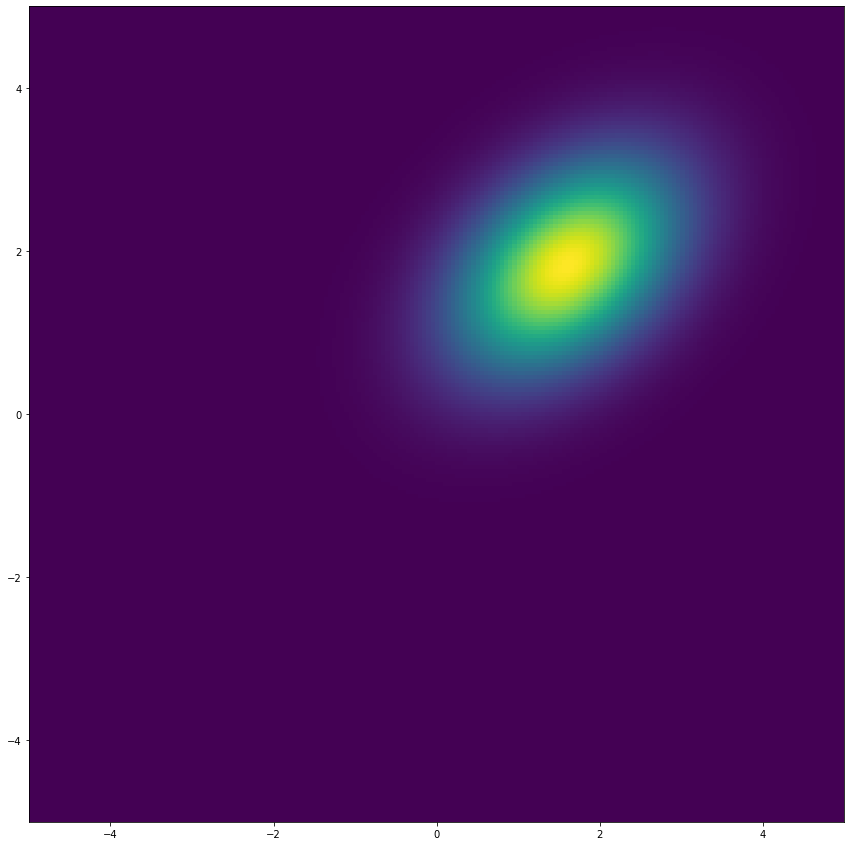

 41%|████      | 16499/40000 [09:19<1:12:44,  5.38it/s]

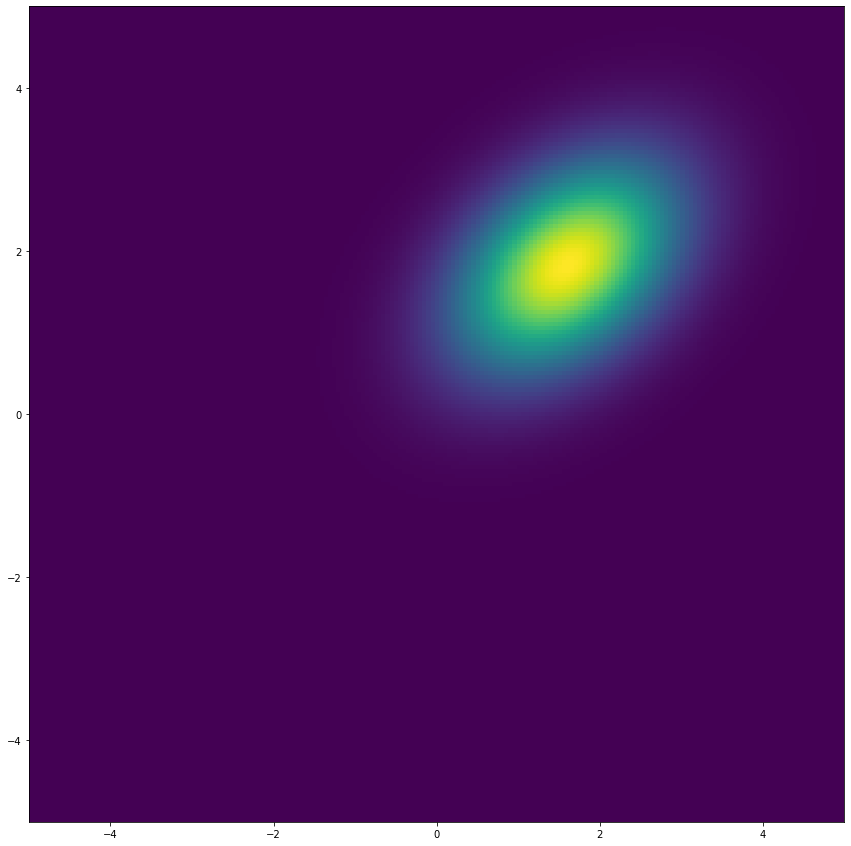

 42%|████▏     | 16998/40000 [09:40<13:19, 28.77it/s]  

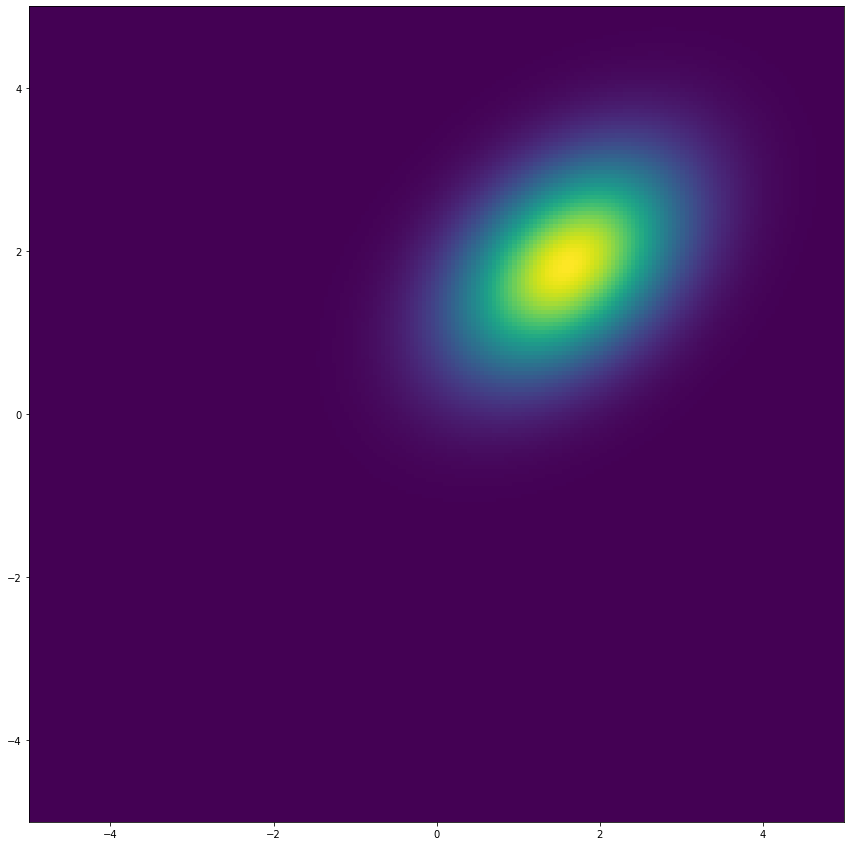

 44%|████▎     | 17496/40000 [09:56<10:55, 34.32it/s]

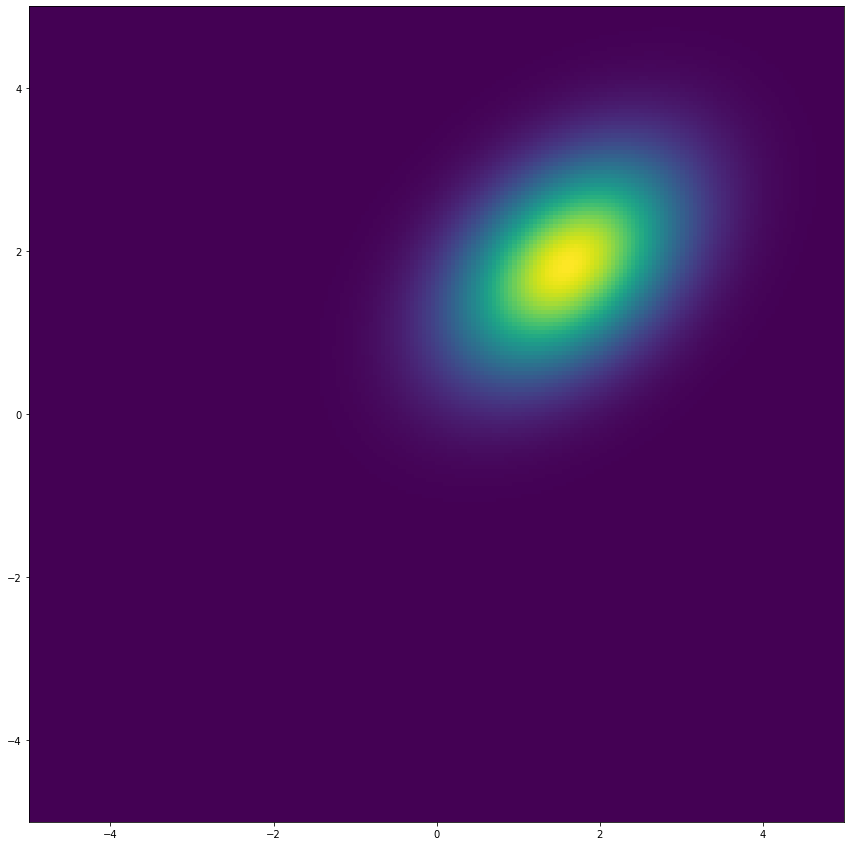

 45%|████▍     | 17999/40000 [10:24<17:43, 20.69it/s]

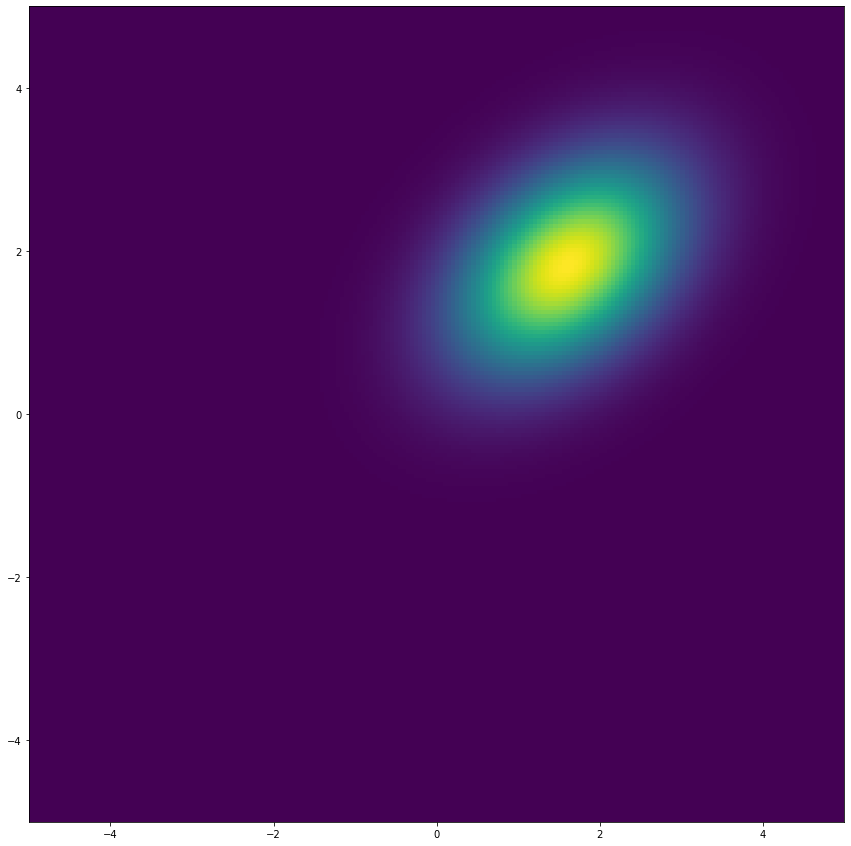

 46%|████▌     | 18498/40000 [10:49<12:33, 28.53it/s]  

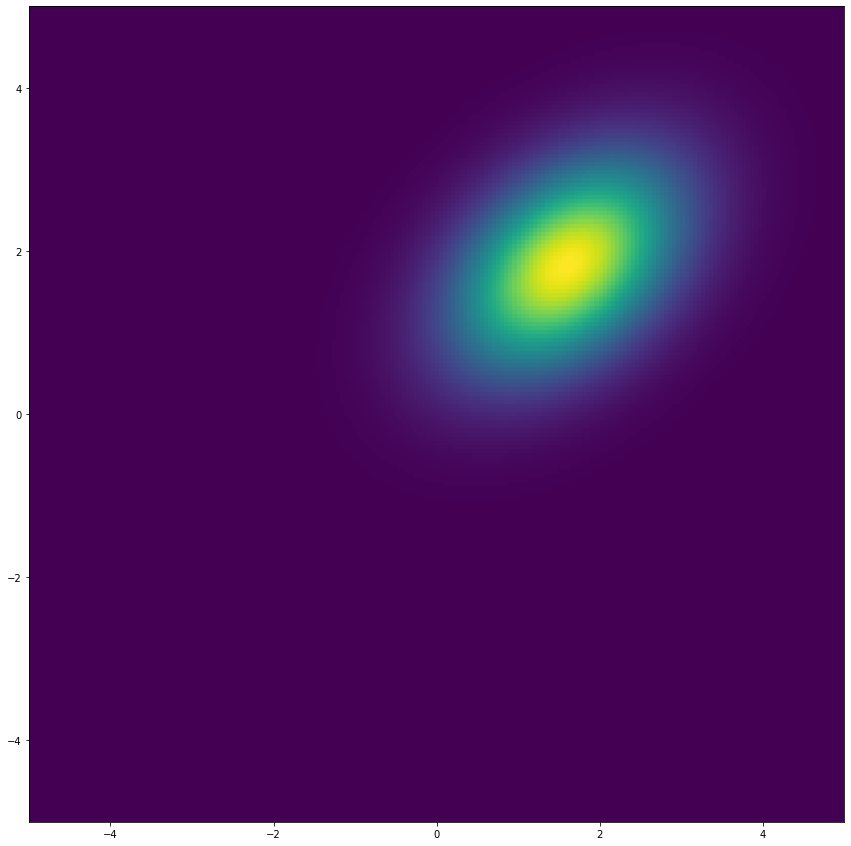

 47%|████▋     | 18999/40000 [11:08<11:40, 29.97it/s]

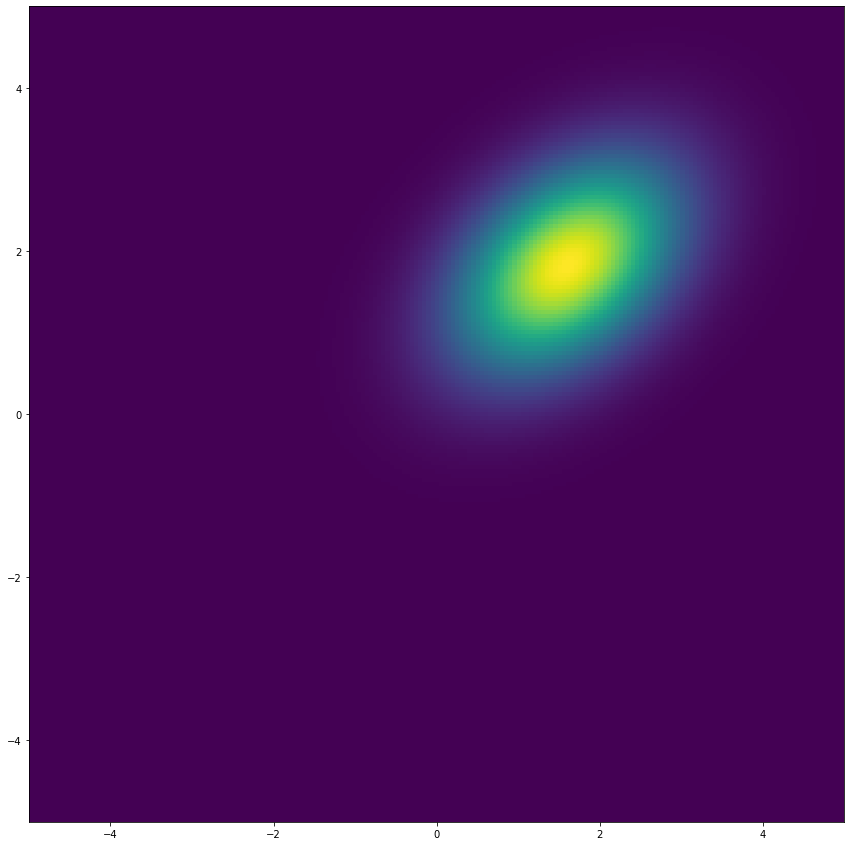

 49%|████▊     | 19499/40000 [11:30<10:52, 31.41it/s]

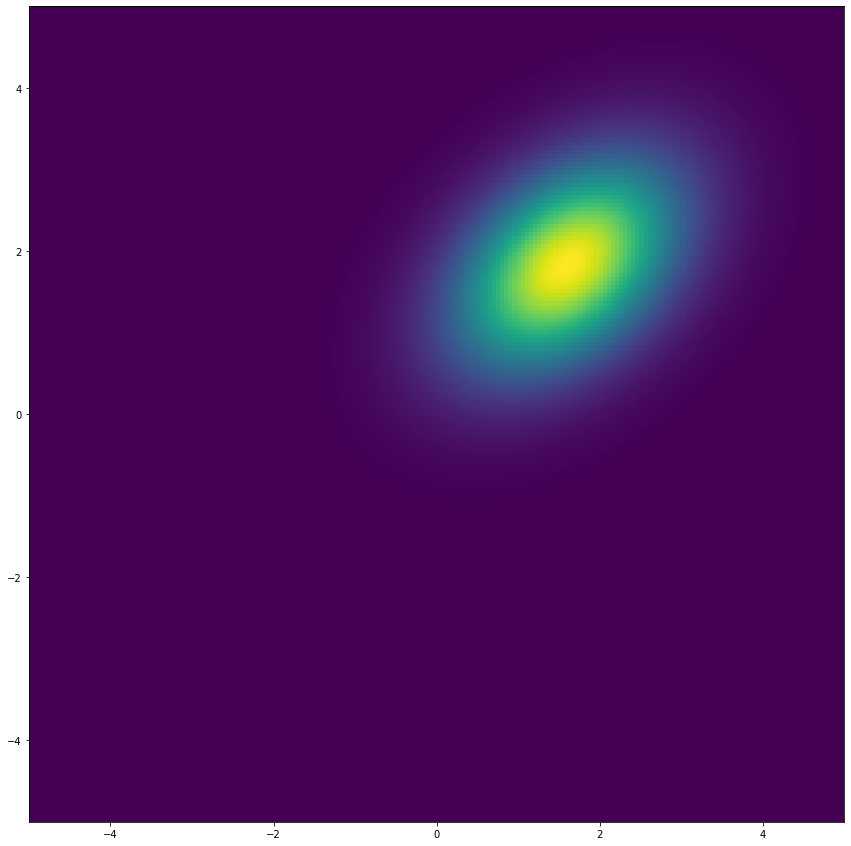

 50%|████▉     | 19997/40000 [11:48<19:02, 17.51it/s]

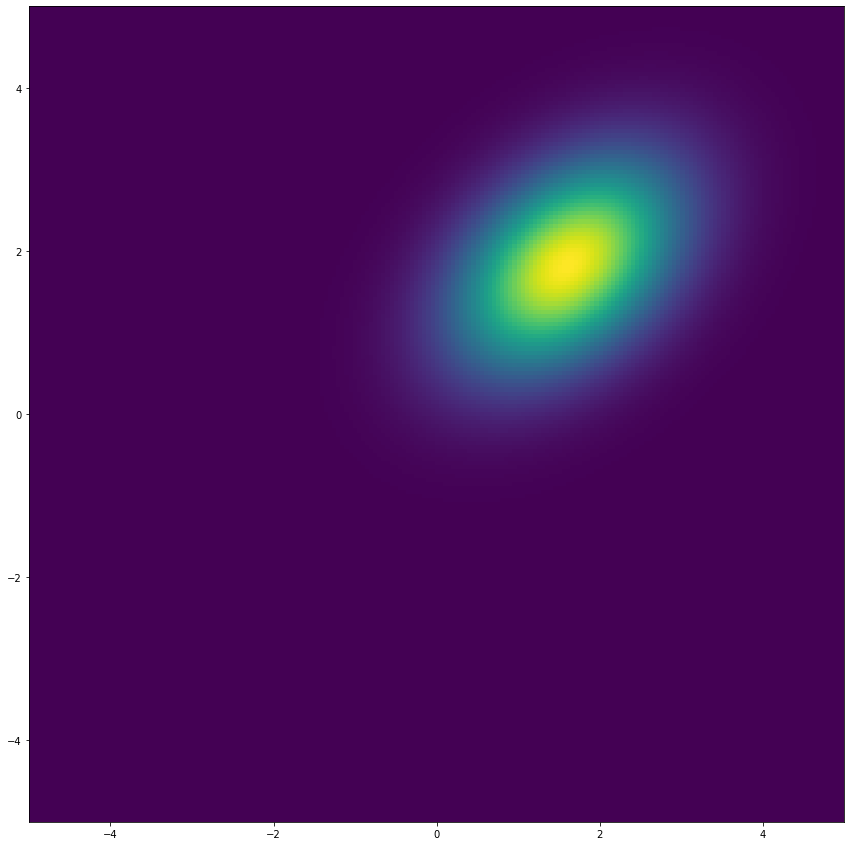

 51%|█████     | 20497/40000 [12:08<10:34, 30.76it/s]

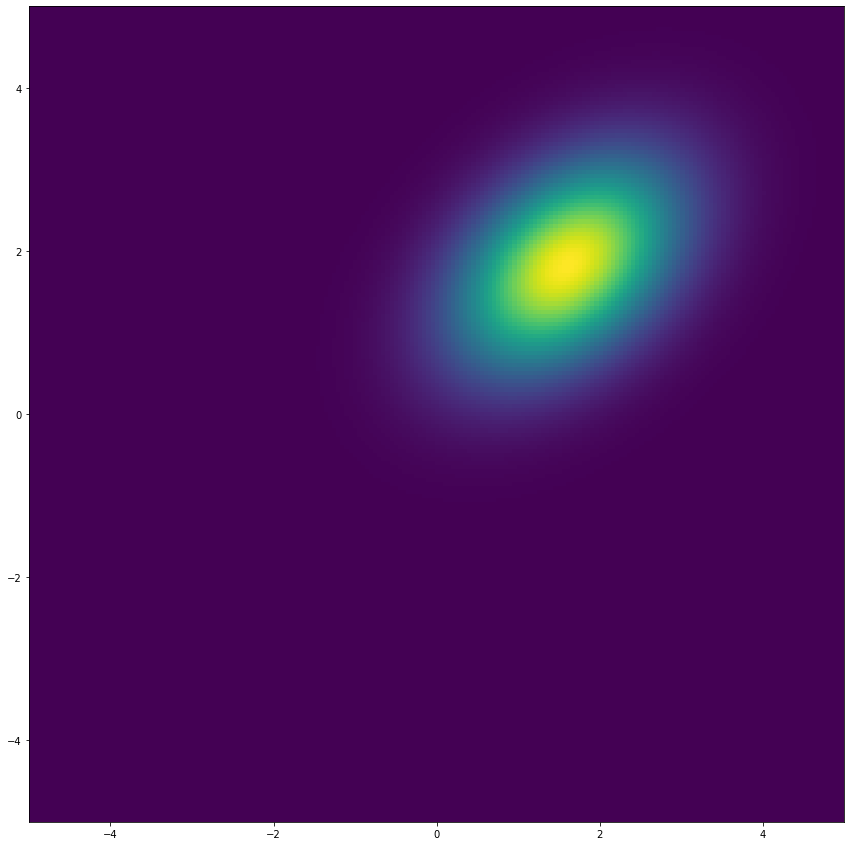

 52%|█████▏    | 20998/40000 [12:31<09:06, 34.76it/s]

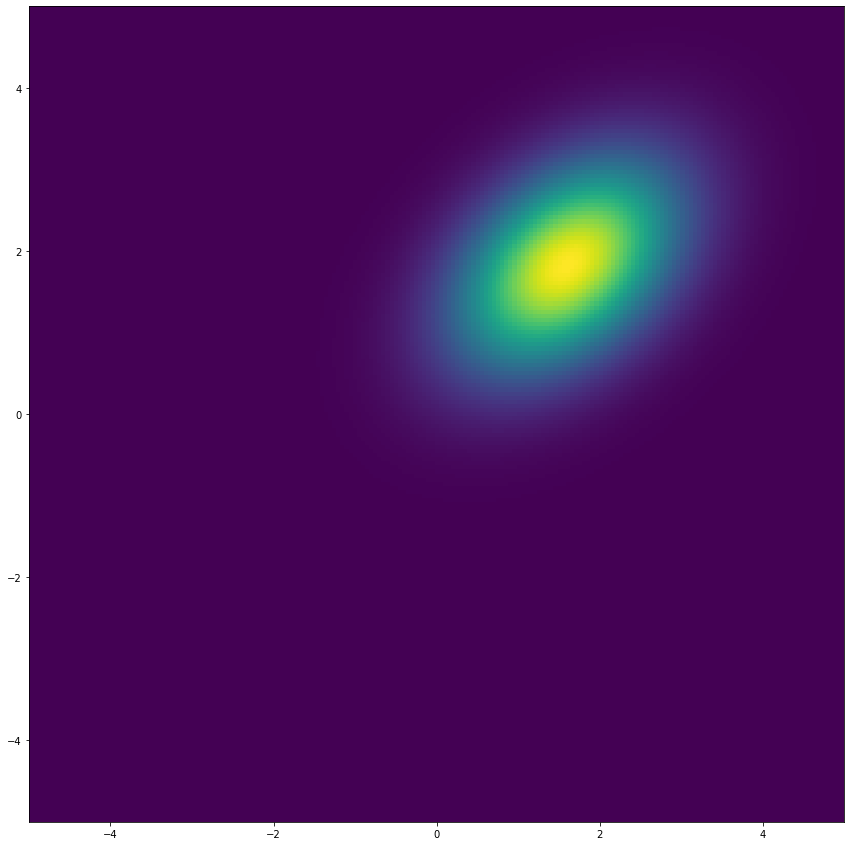

 54%|█████▎    | 21497/40000 [12:47<09:26, 32.67it/s]

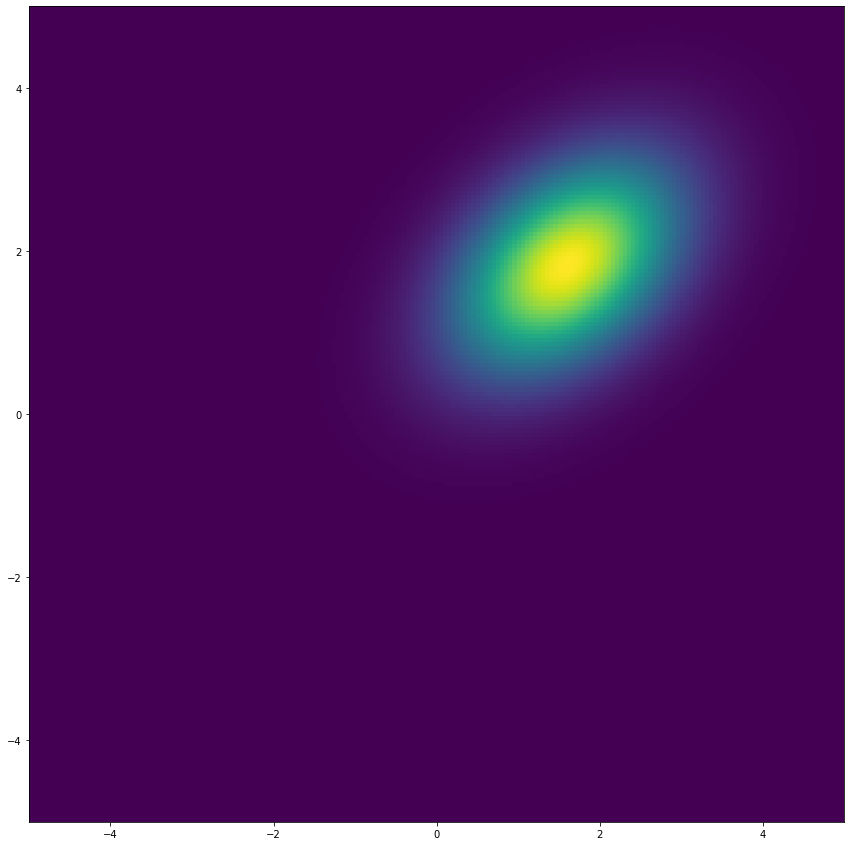

 55%|█████▍    | 21998/40000 [13:07<22:14, 13.49it/s]

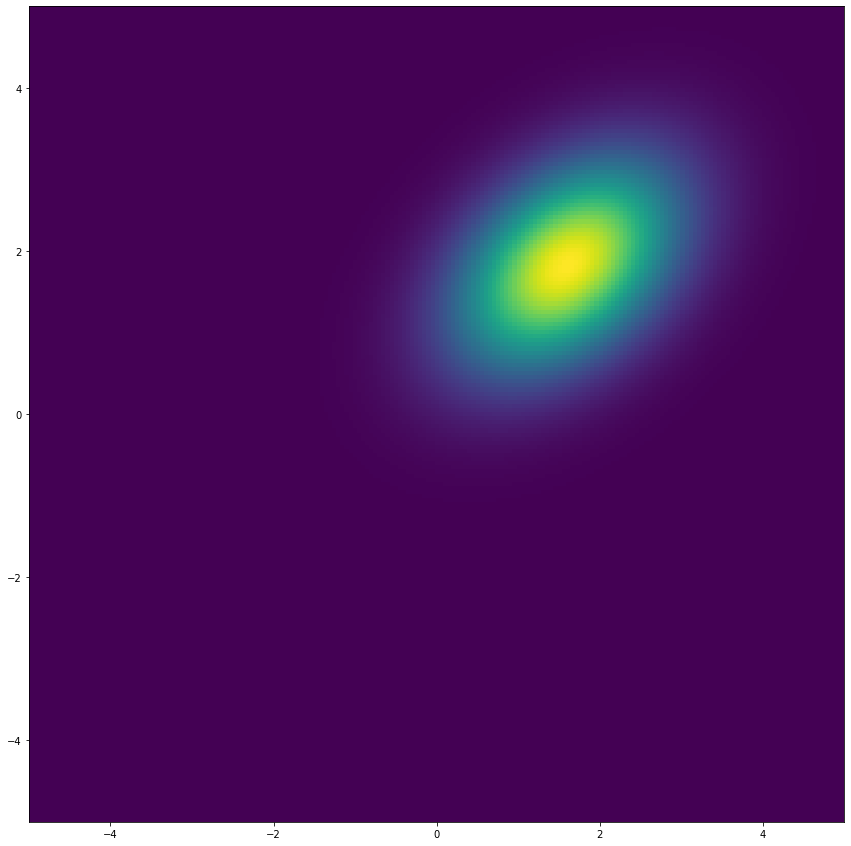

 56%|█████▌    | 22499/40000 [13:30<13:50, 21.08it/s]

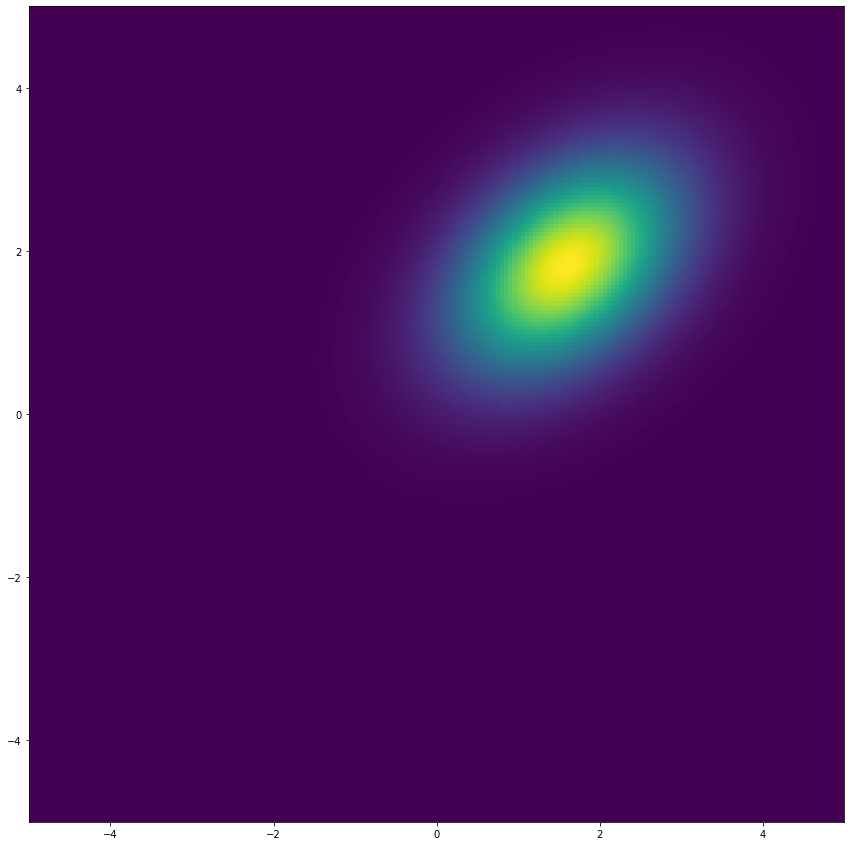

 57%|█████▋    | 22998/40000 [13:46<09:24, 30.12it/s]

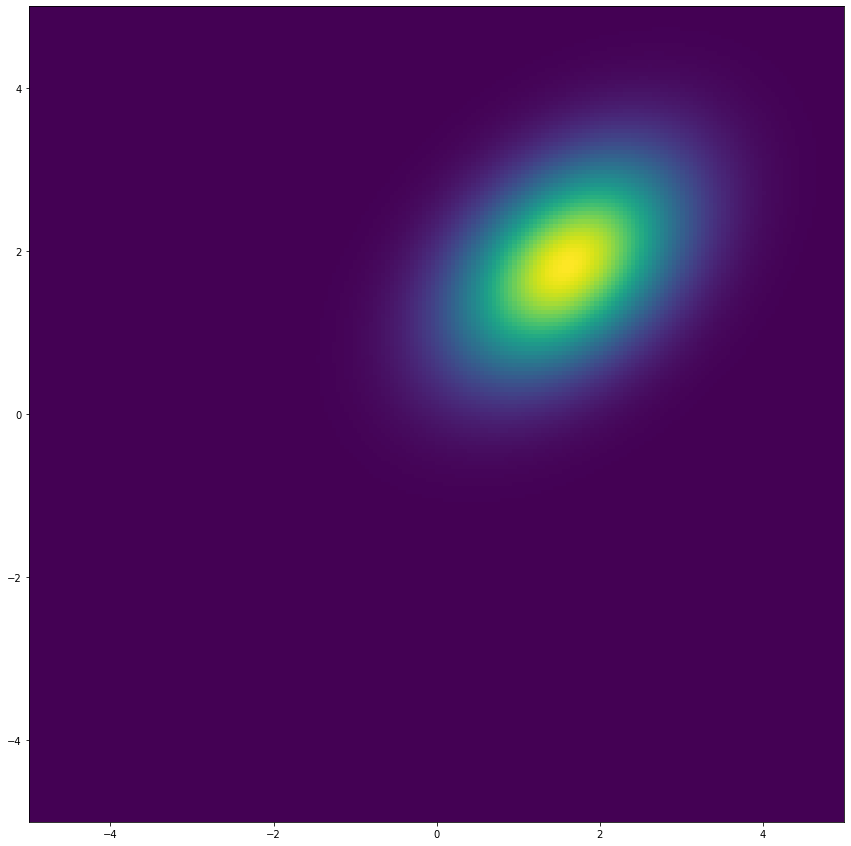

 59%|█████▊    | 23498/40000 [14:01<07:33, 36.42it/s]

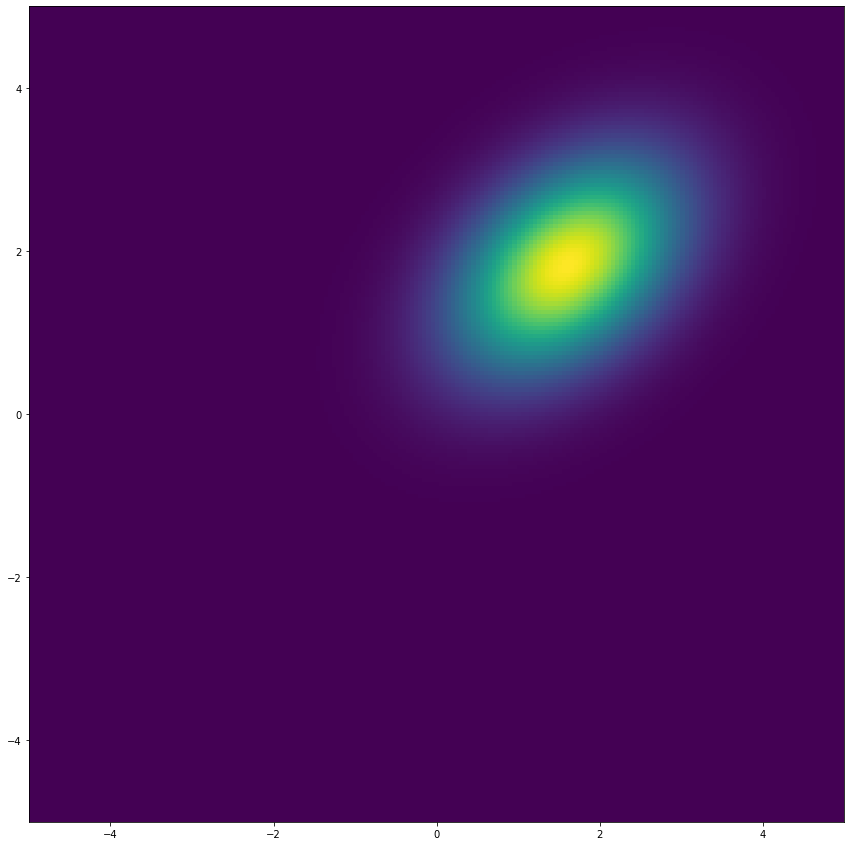

 60%|█████▉    | 23996/40000 [14:17<07:36, 35.04it/s]

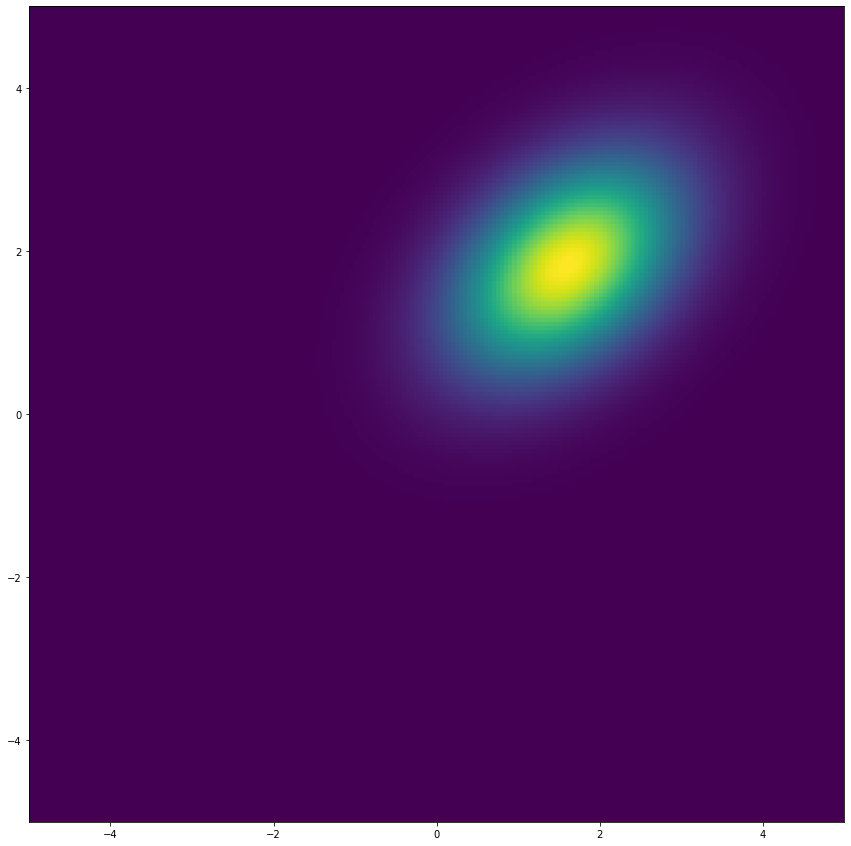

 61%|██████    | 24499/40000 [14:32<07:26, 34.68it/s]

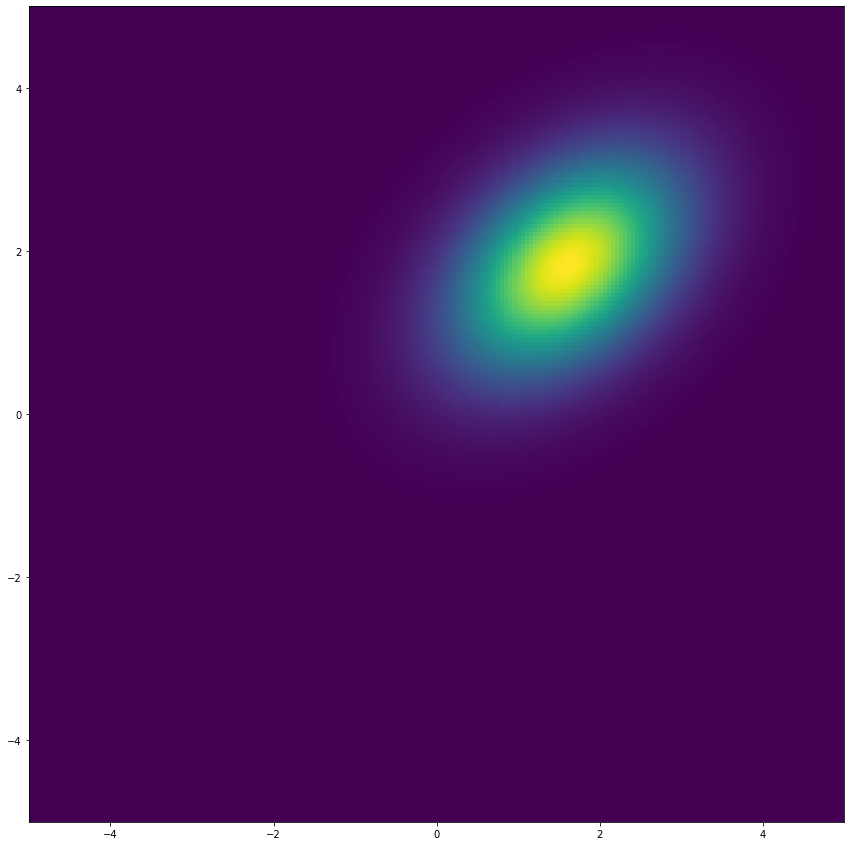

 62%|██████▏   | 24996/40000 [14:48<07:59, 31.28it/s]

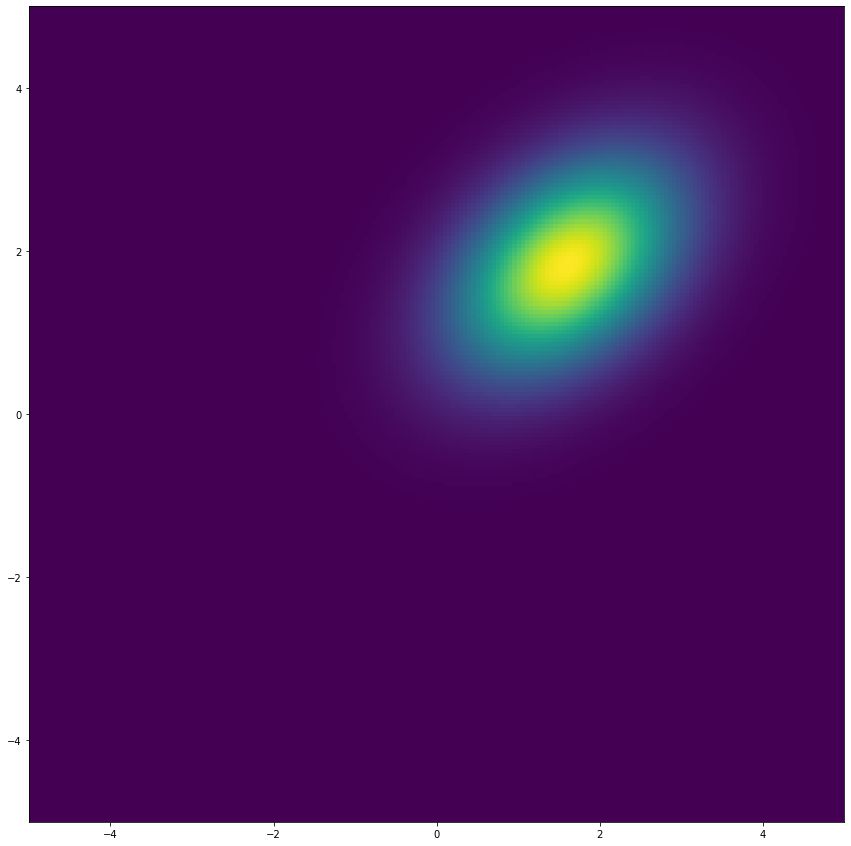

 64%|██████▎   | 25496/40000 [15:06<08:15, 29.26it/s]

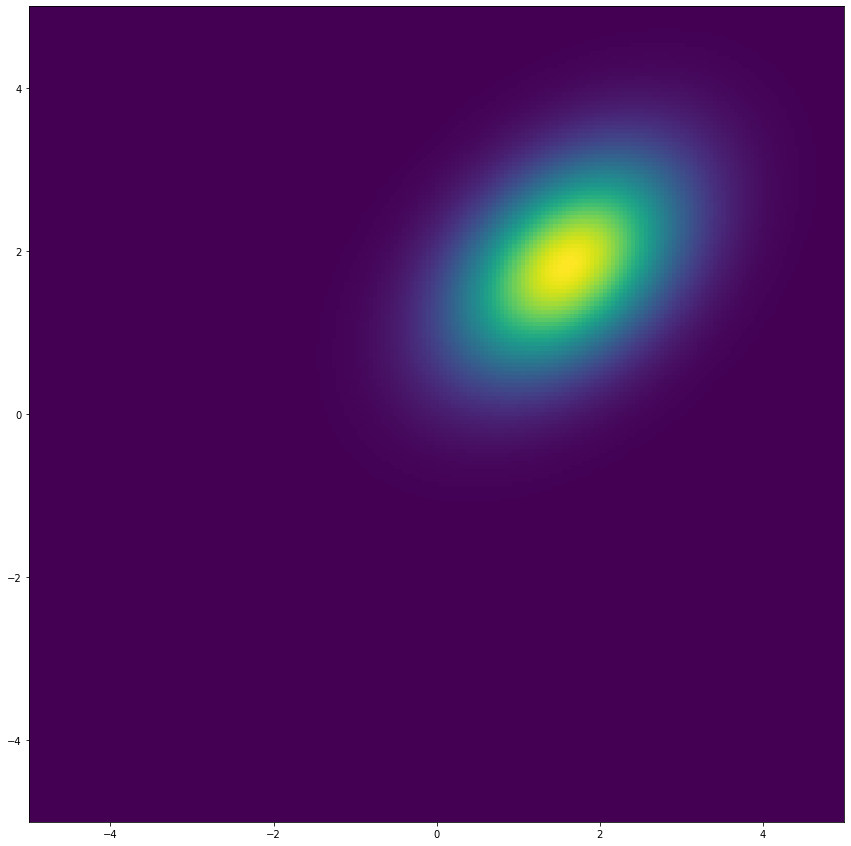

 65%|██████▍   | 25998/40000 [15:24<08:30, 27.42it/s]

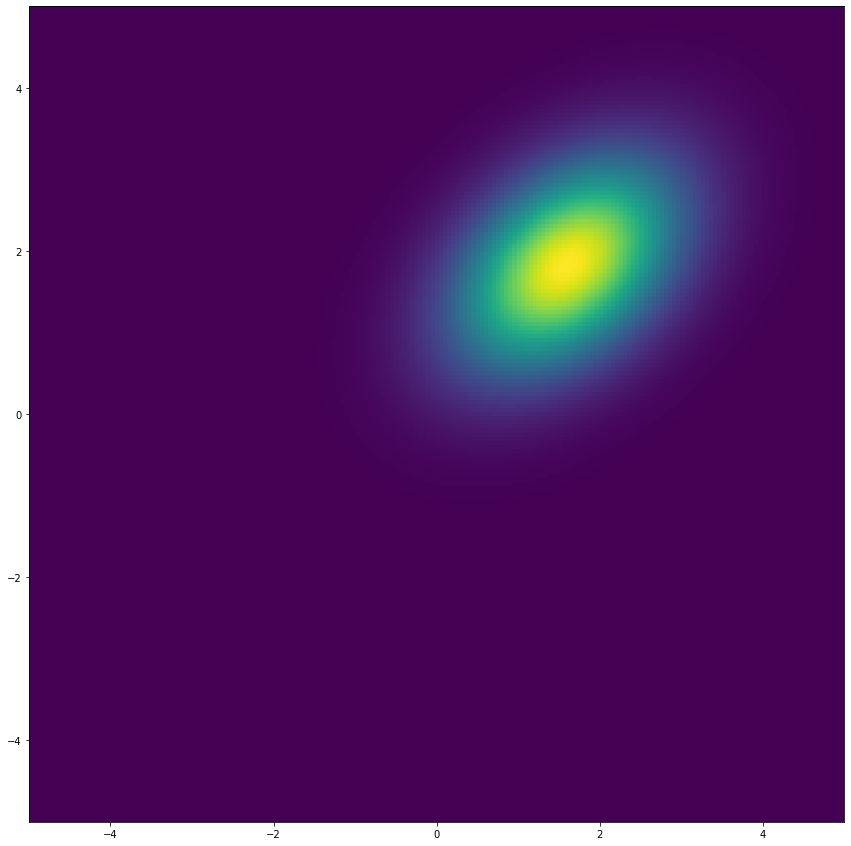

 66%|██████▌   | 26496/40000 [15:40<07:05, 31.75it/s]

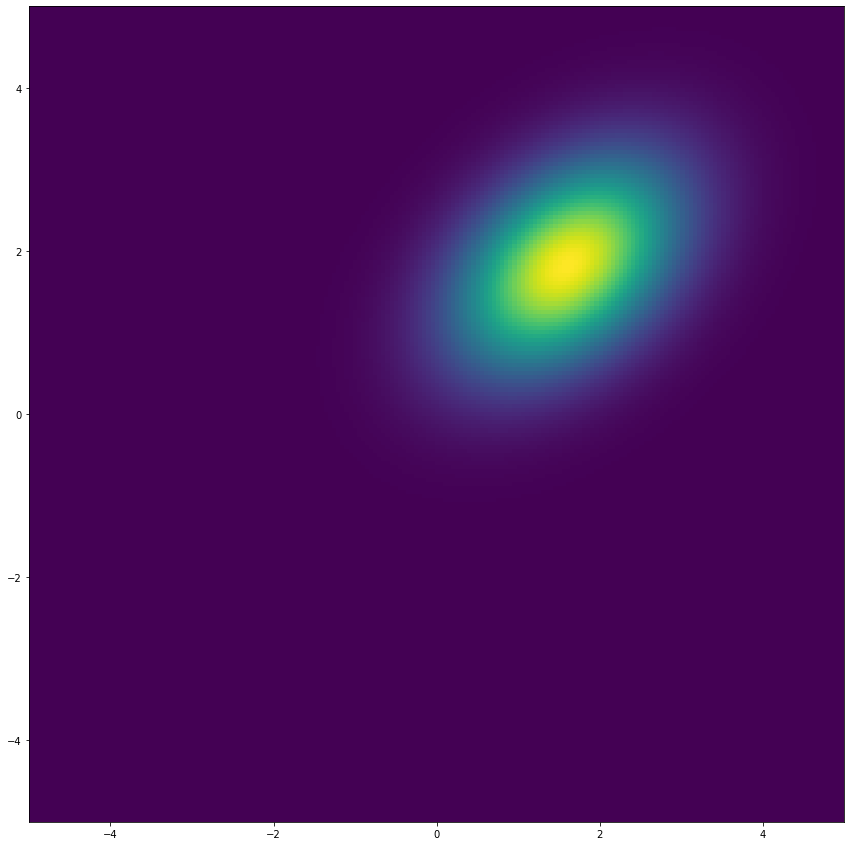

 67%|██████▋   | 26997/40000 [15:59<07:09, 30.29it/s]

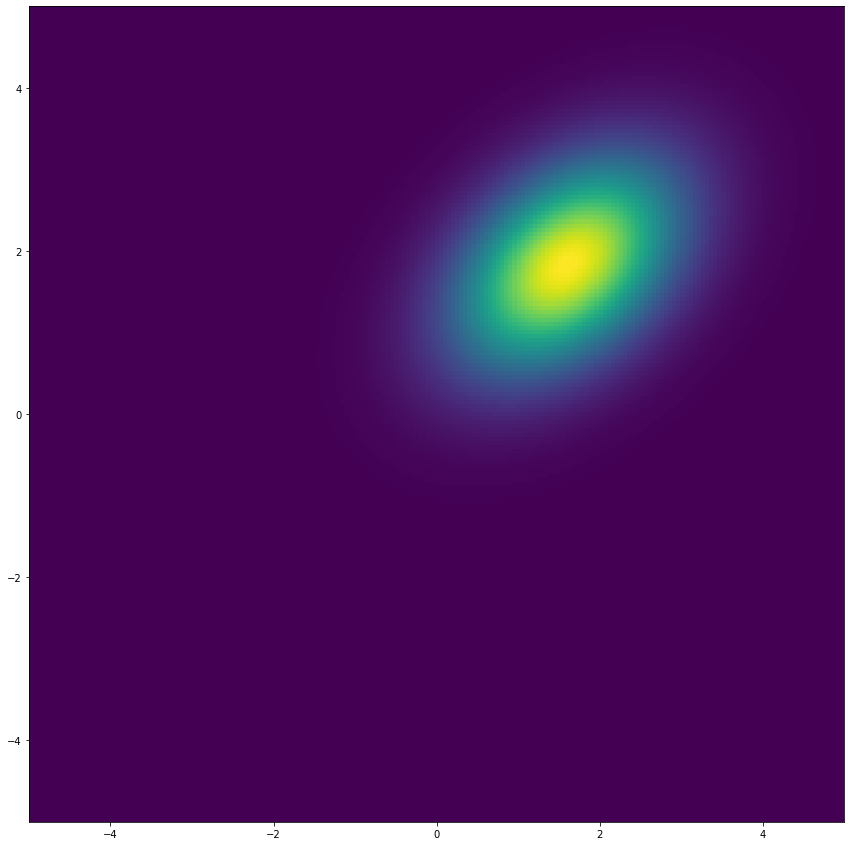

 69%|██████▊   | 27498/40000 [16:17<06:50, 30.45it/s]

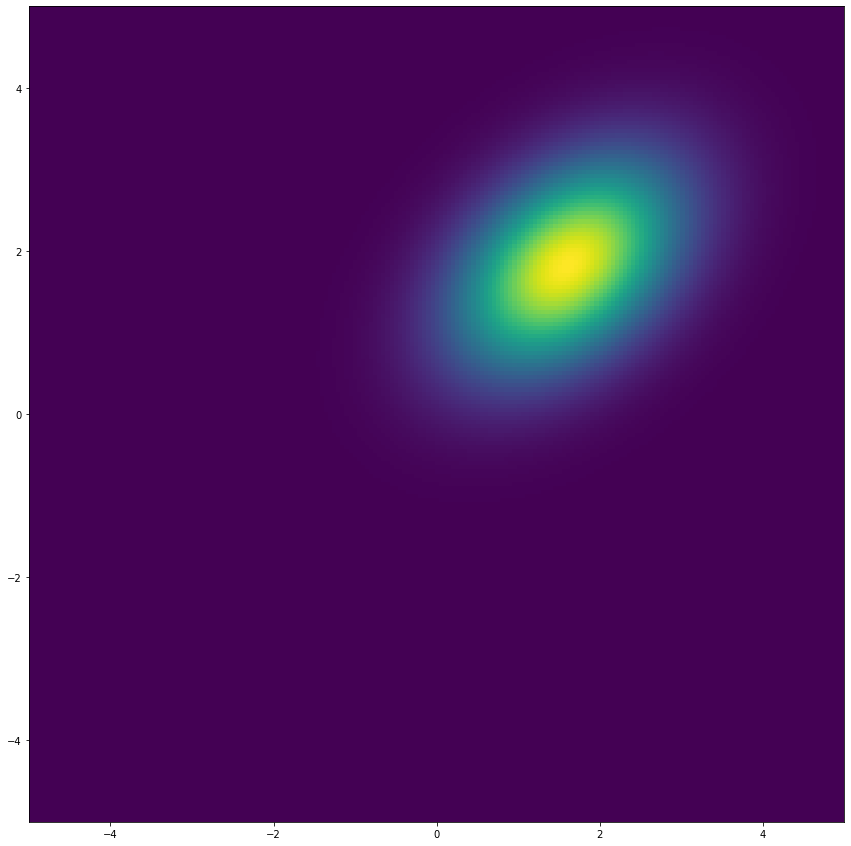

 70%|██████▉   | 27998/40000 [16:38<10:58, 18.23it/s]

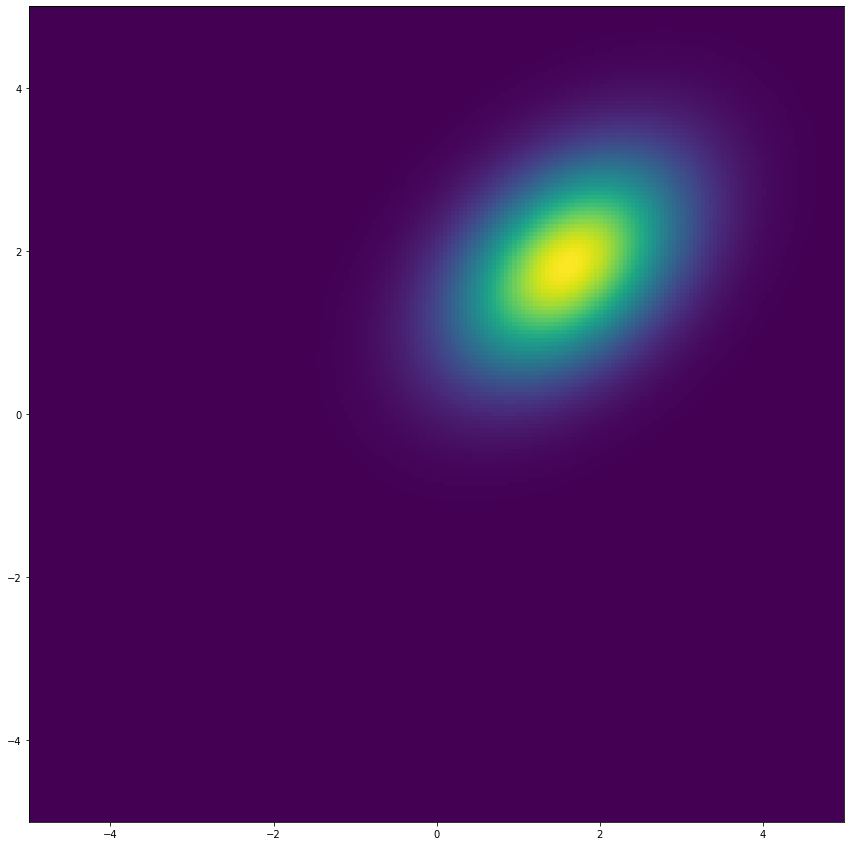

 71%|███████   | 28499/40000 [16:55<06:22, 30.08it/s]

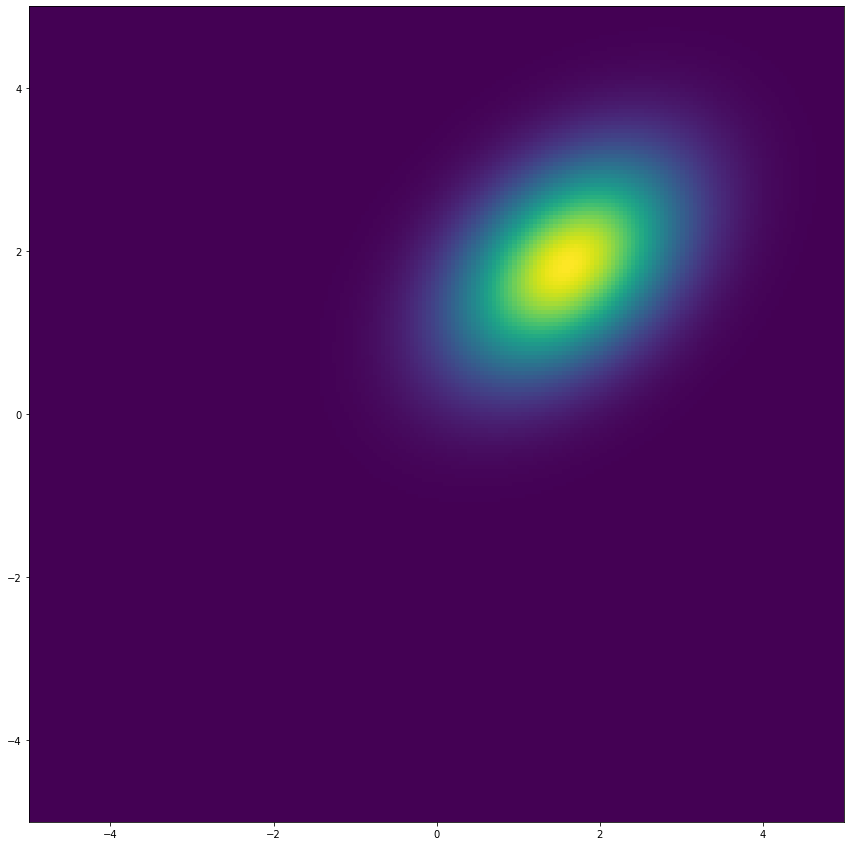

 72%|███████▏  | 28998/40000 [17:12<05:19, 34.40it/s]

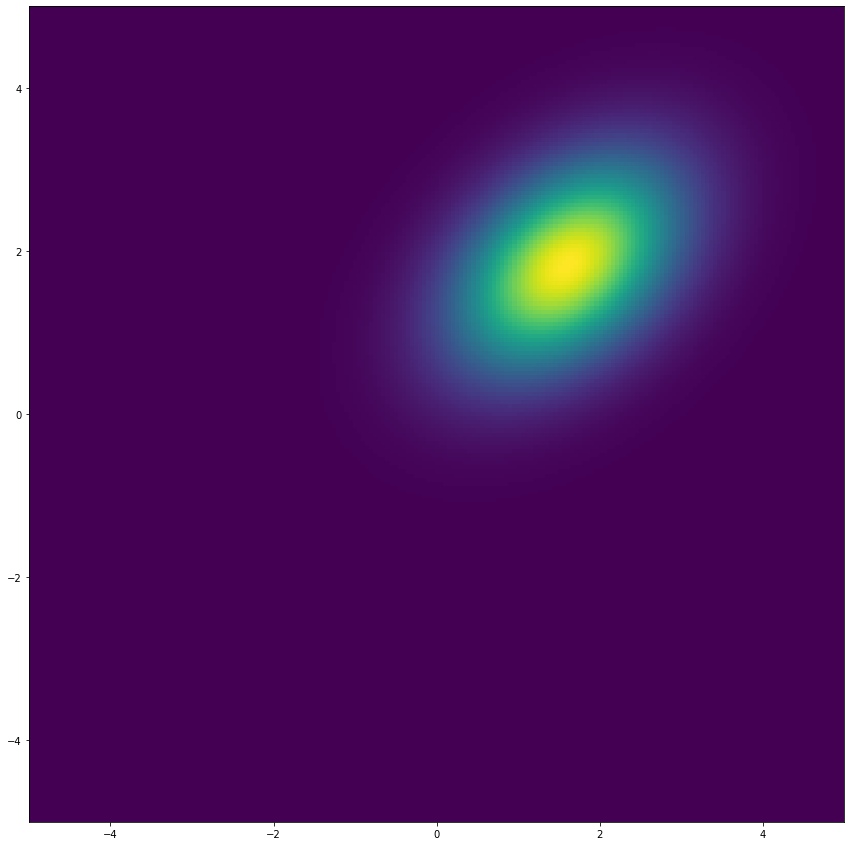

 74%|███████▎  | 29496/40000 [17:29<05:56, 29.49it/s]

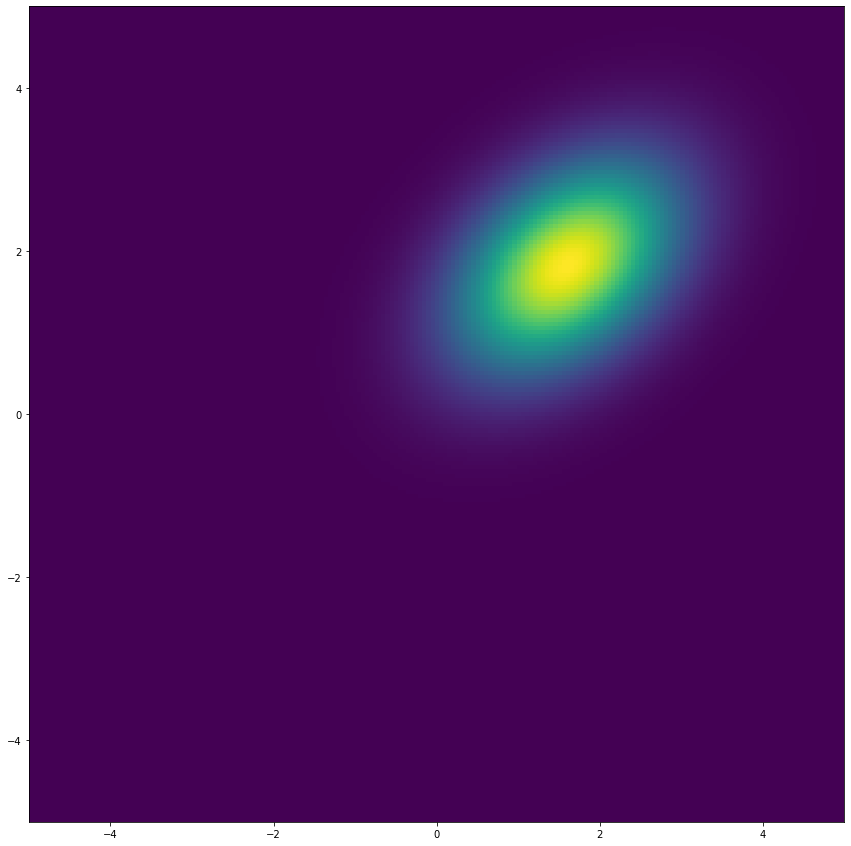

 75%|███████▍  | 29999/40000 [17:46<06:22, 26.14it/s]

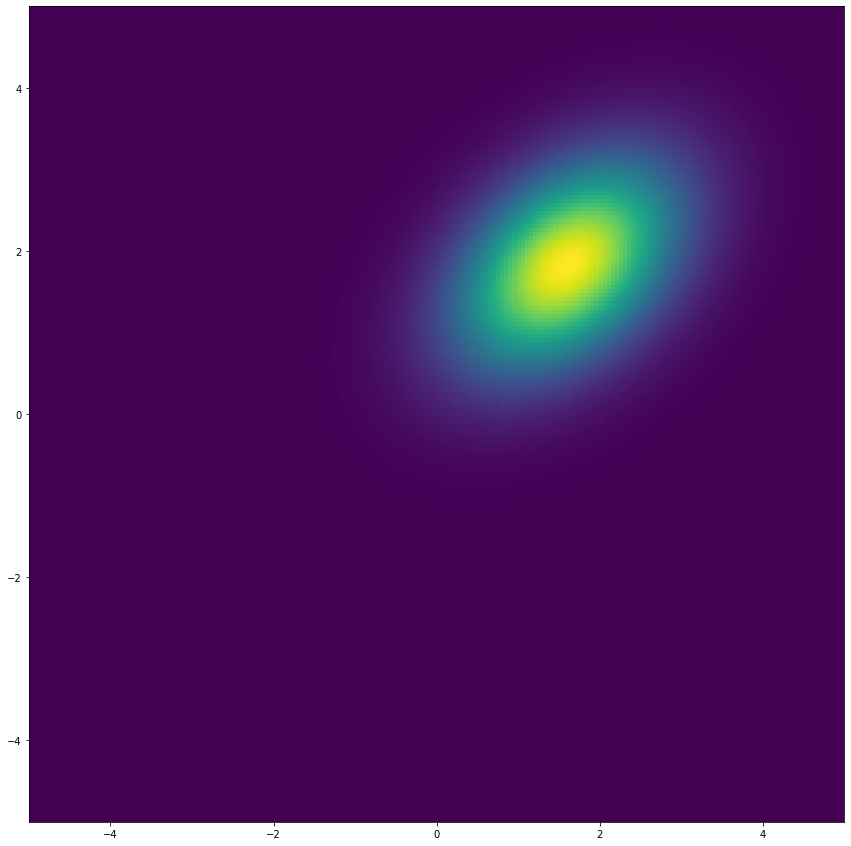

 76%|███████▌  | 30498/40000 [18:03<05:37, 28.15it/s]

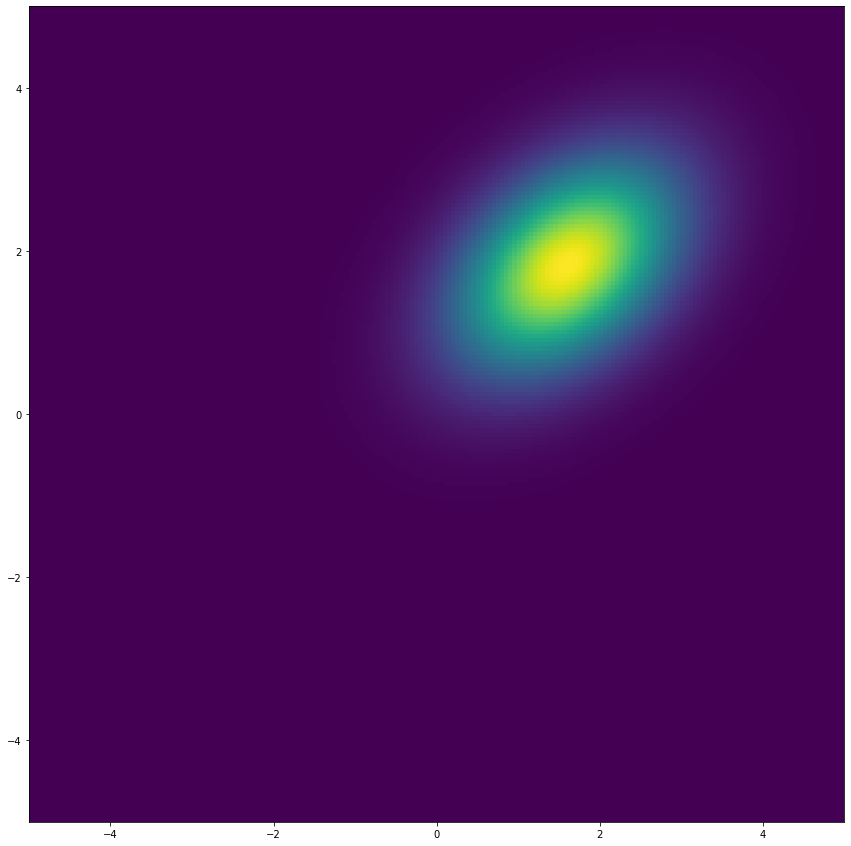

 77%|███████▋  | 30996/40000 [18:20<04:56, 30.38it/s]

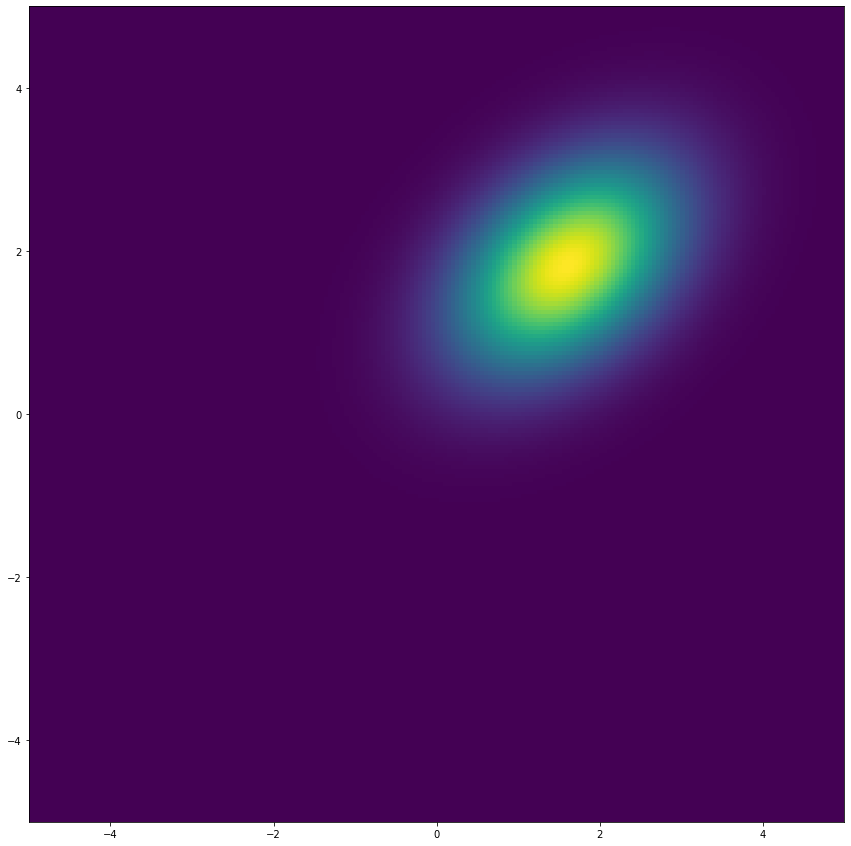

 79%|███████▊  | 31499/40000 [18:36<05:37, 25.17it/s]

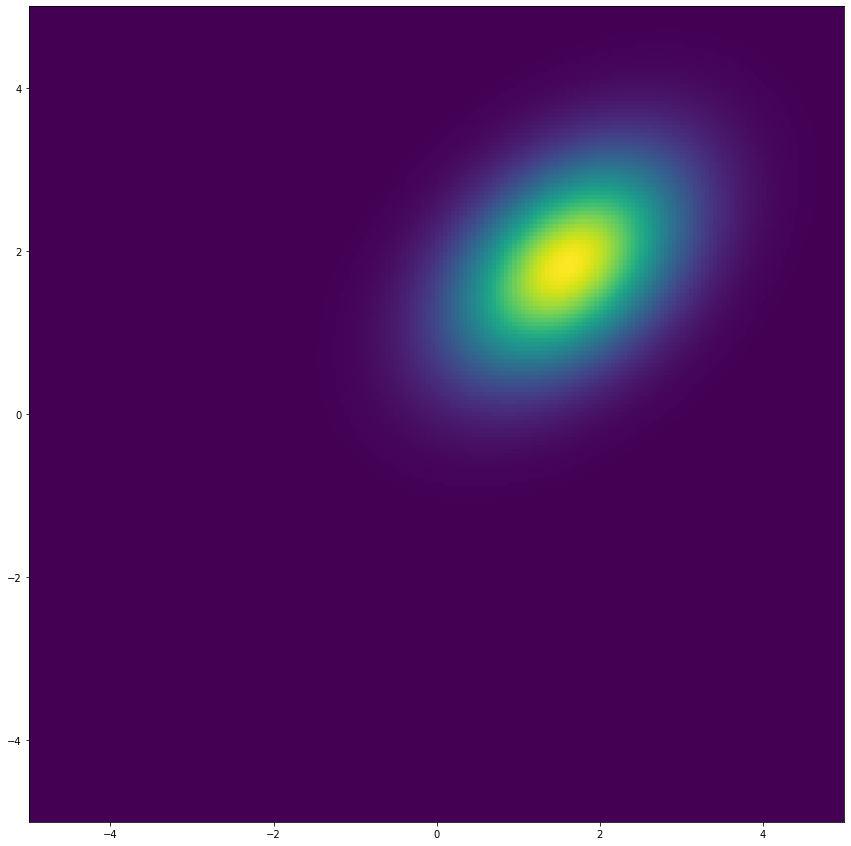

 80%|███████▉  | 31999/40000 [18:54<04:15, 31.32it/s]

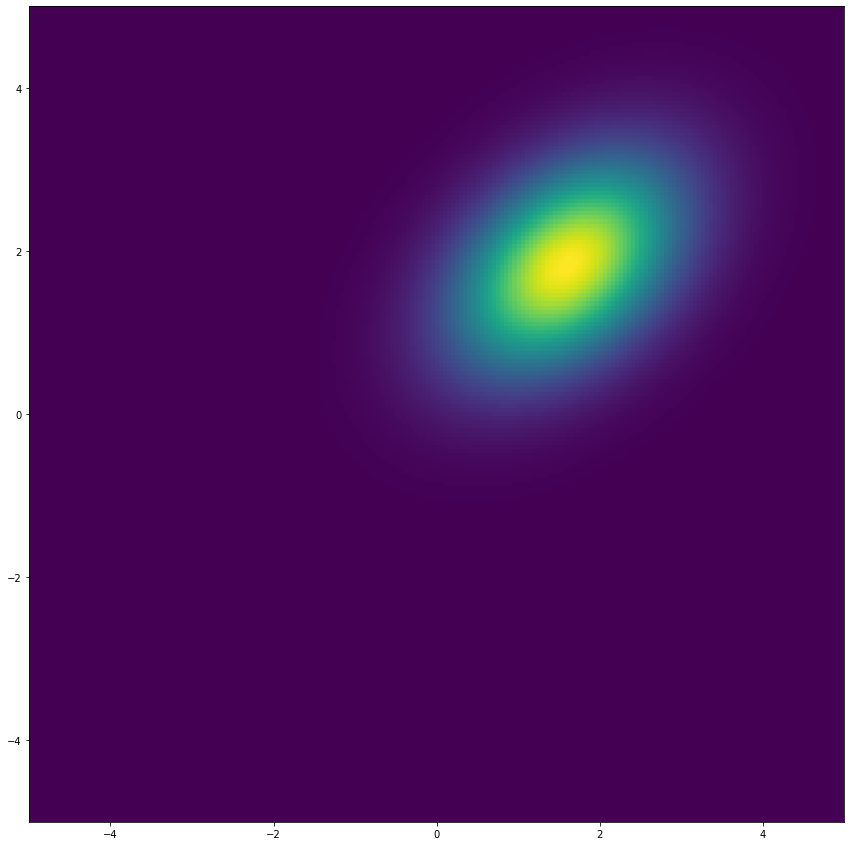

 81%|████████  | 32496/40000 [19:10<03:37, 34.54it/s]

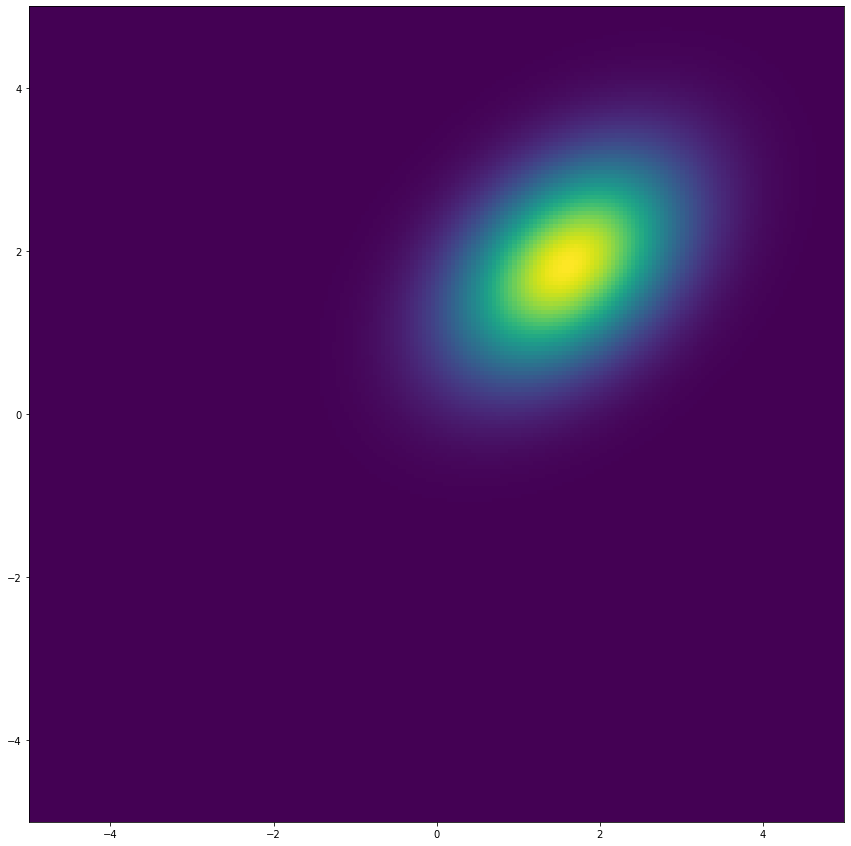

 82%|████████▏ | 32996/40000 [19:27<03:42, 31.48it/s]

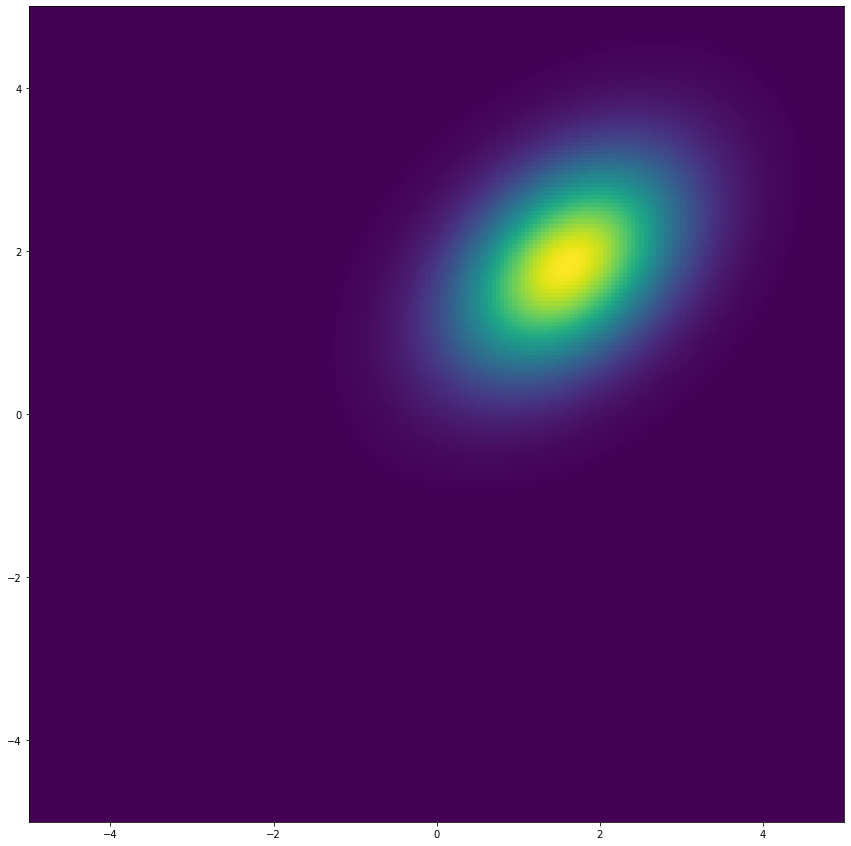

 84%|████████▎ | 33497/40000 [19:44<03:24, 31.82it/s]

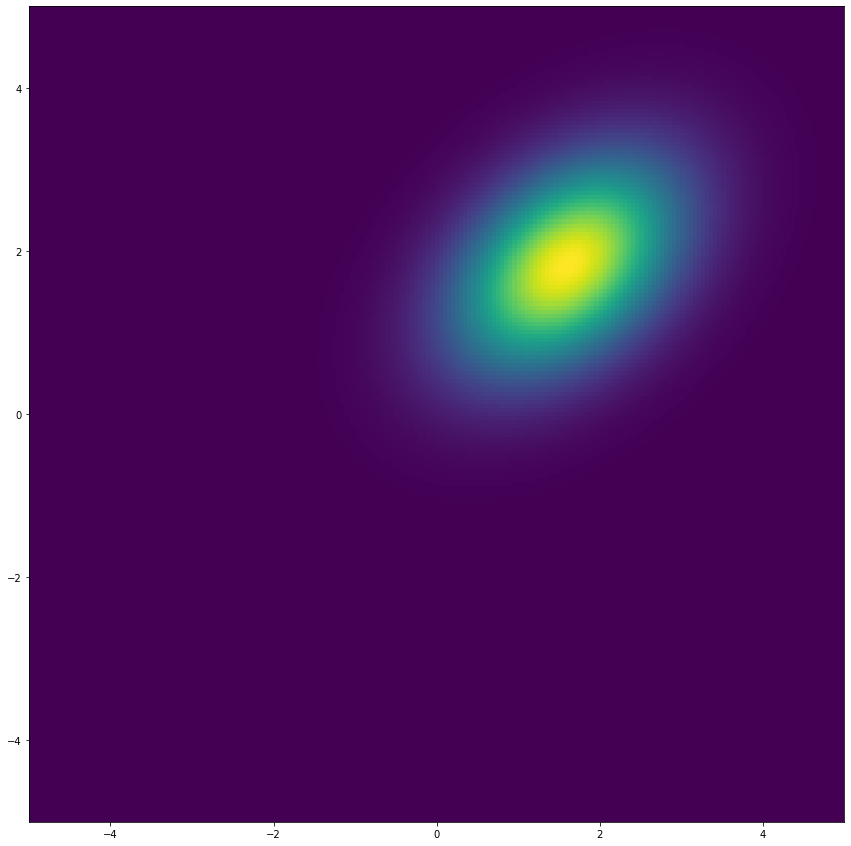

 85%|████████▍ | 33999/40000 [20:07<04:04, 24.55it/s]

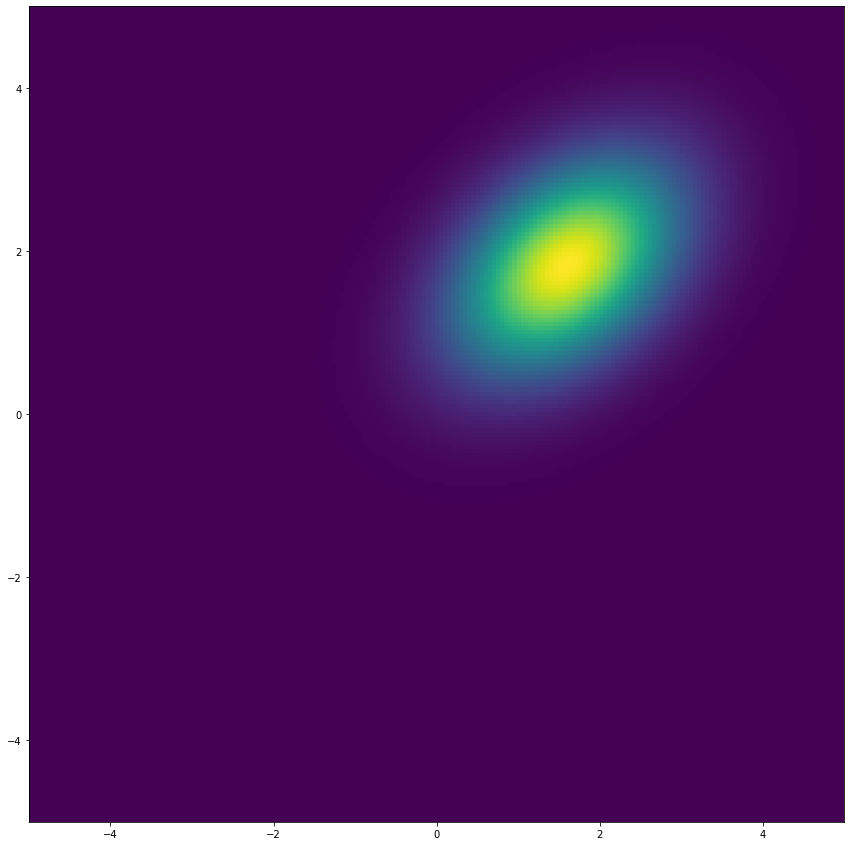

 86%|████████▌ | 34496/40000 [20:25<03:02, 30.09it/s]

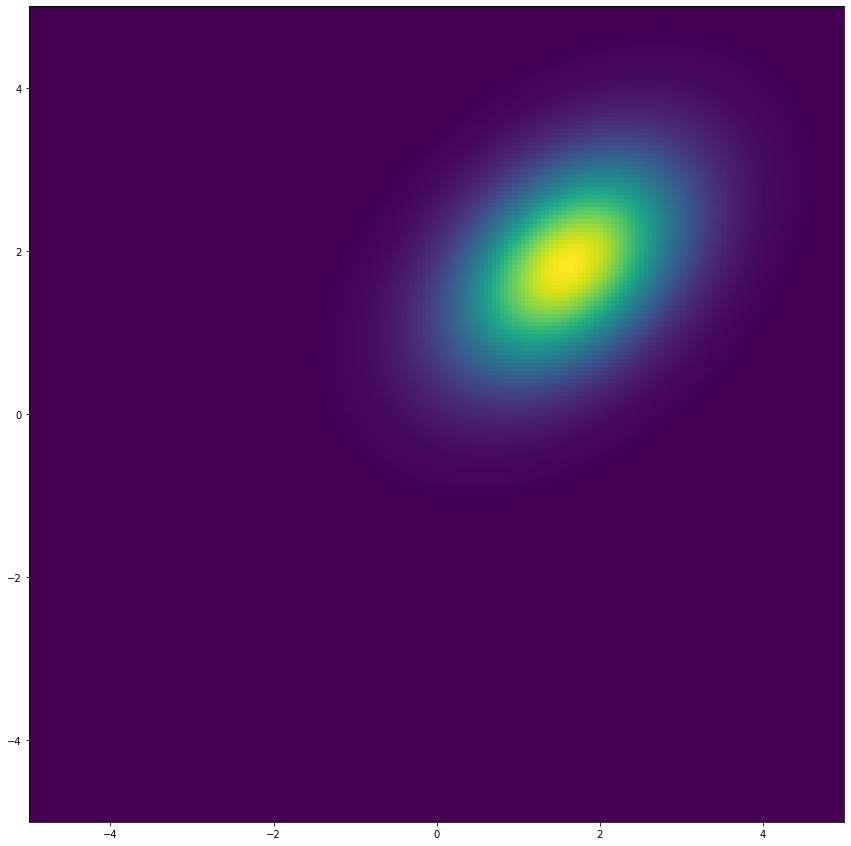

 87%|████████▋ | 34997/40000 [20:42<02:42, 30.77it/s]

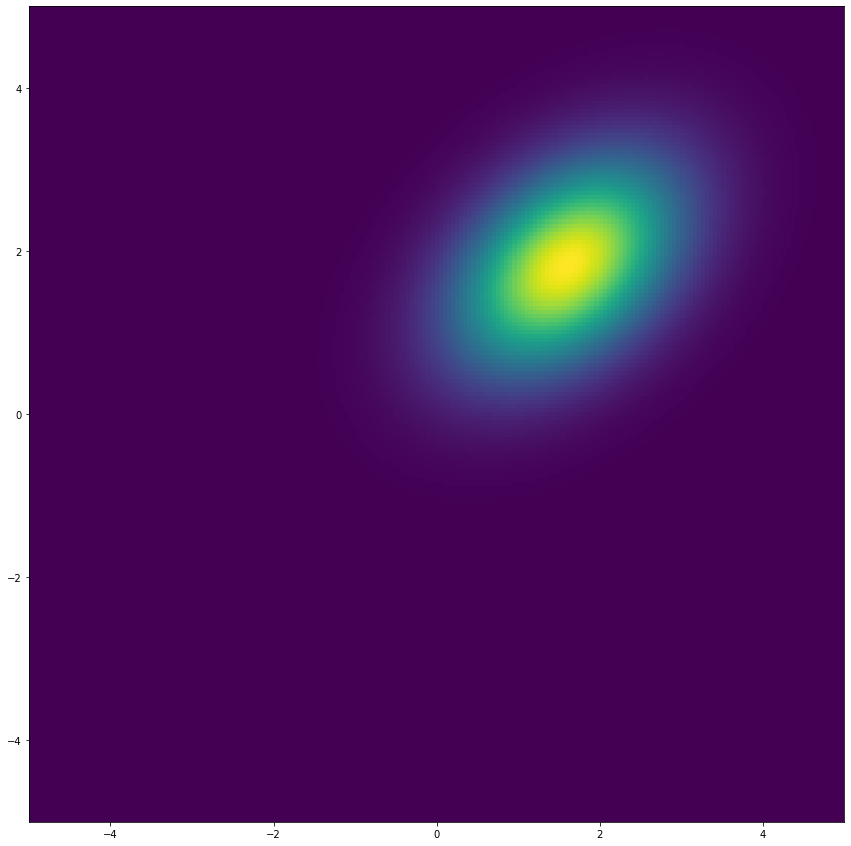

 89%|████████▊ | 35496/40000 [21:00<02:46, 27.08it/s]

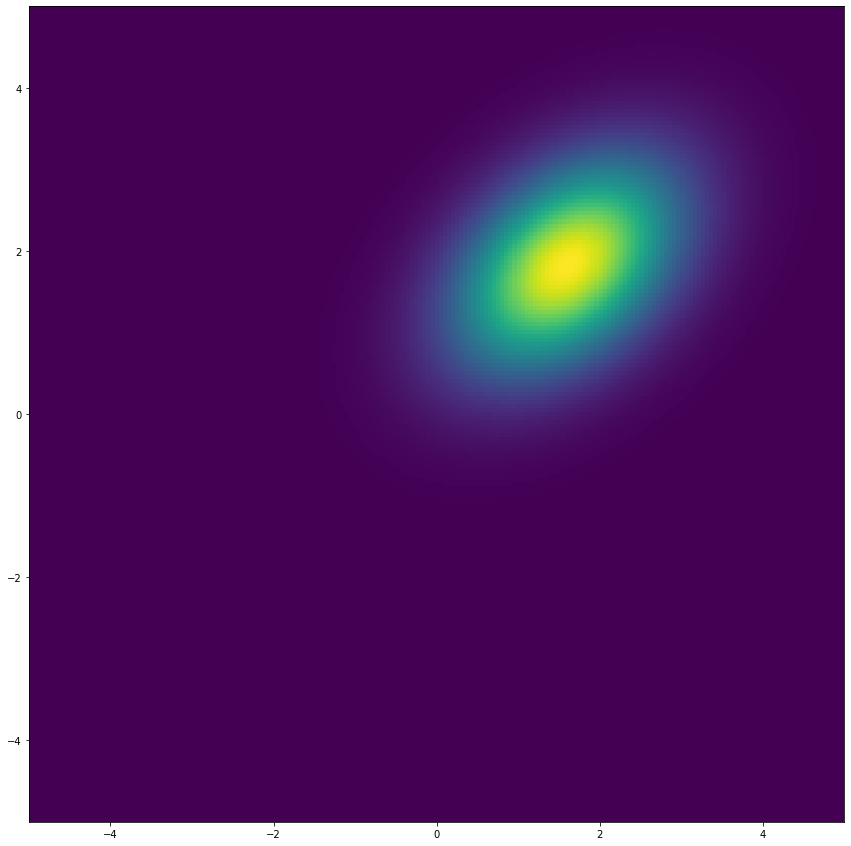

 90%|████████▉ | 35998/40000 [21:18<02:19, 28.59it/s]

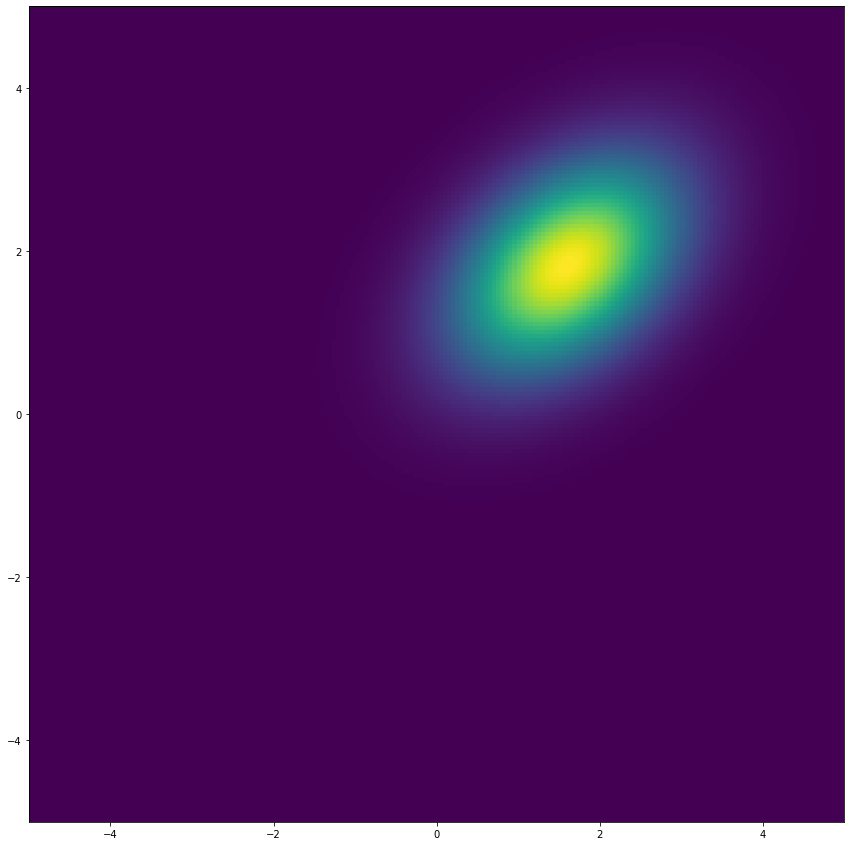

 91%|█████████ | 36499/40000 [21:36<01:59, 29.21it/s]

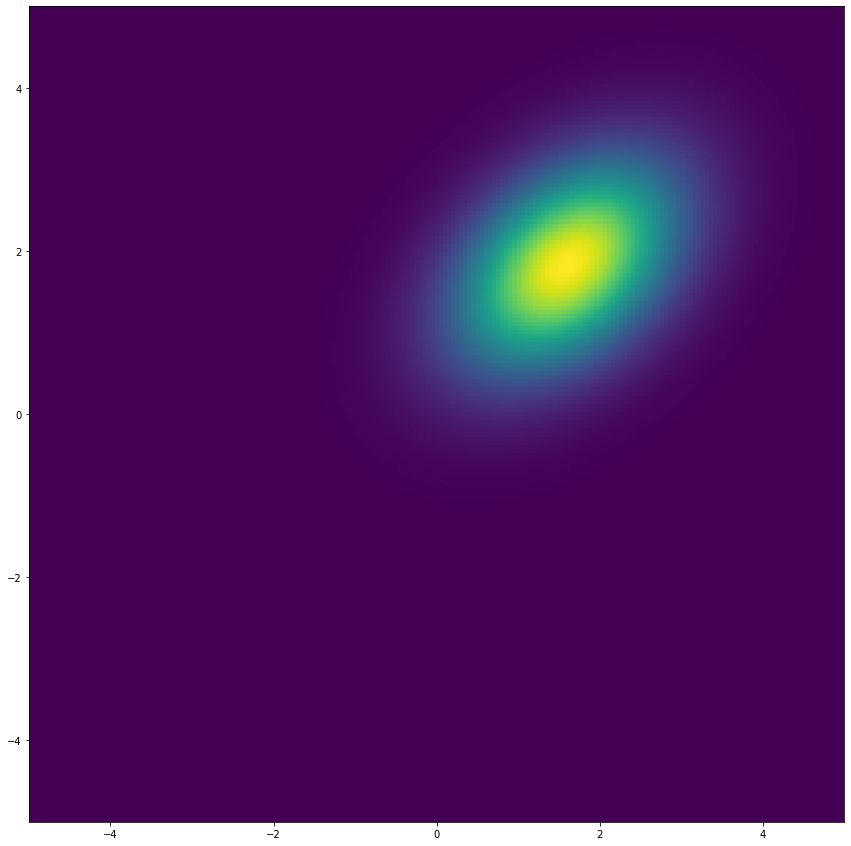

 92%|█████████▏| 36998/40000 [21:54<01:52, 26.72it/s]

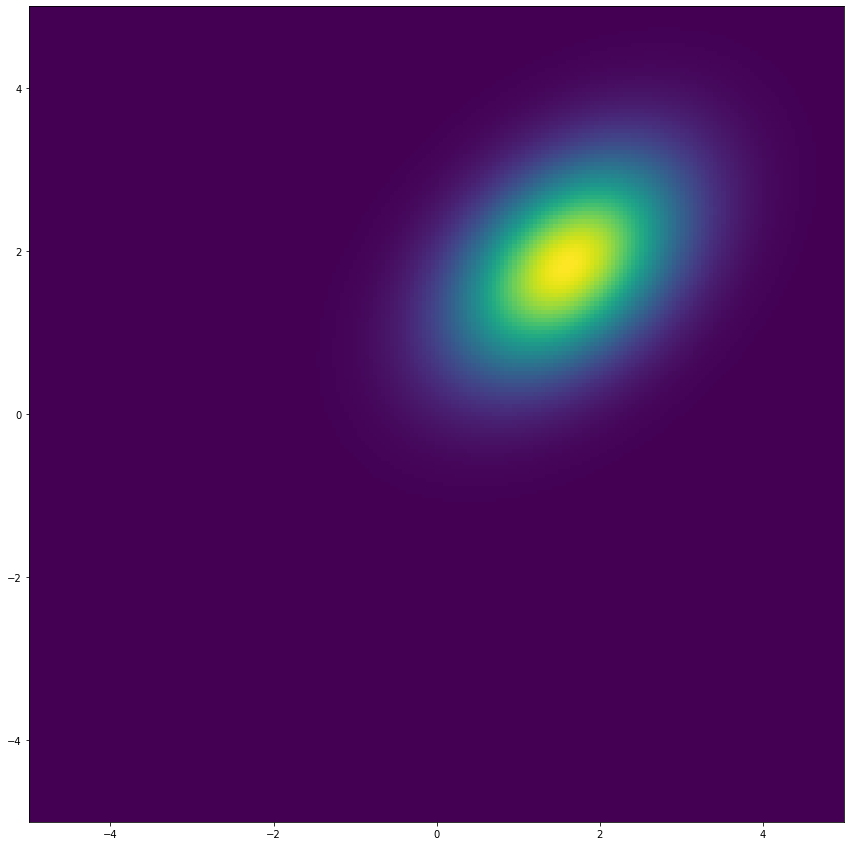

 94%|█████████▎| 37499/40000 [22:13<01:28, 28.29it/s]

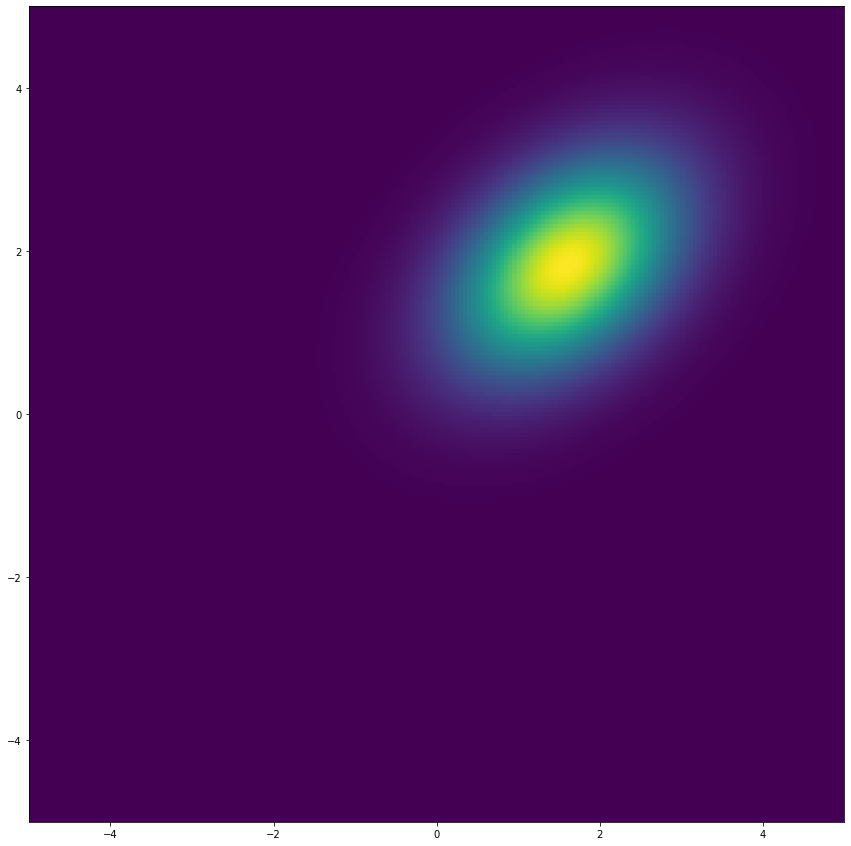

 95%|█████████▍| 37999/40000 [22:31<01:07, 29.80it/s]

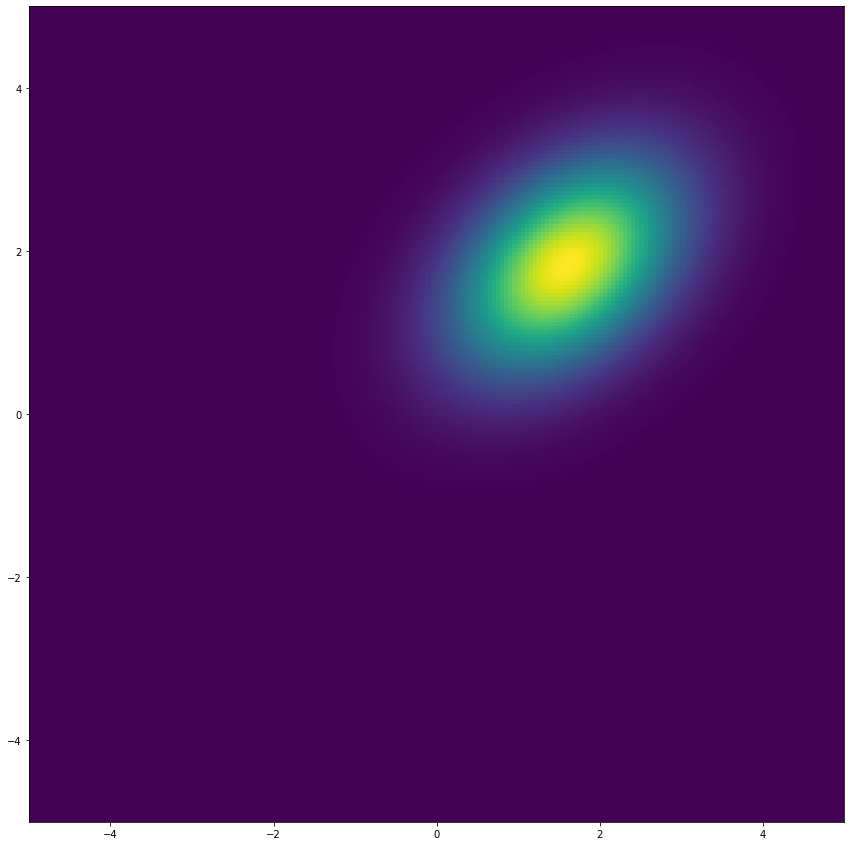

 96%|█████████▌| 38498/40000 [22:47<00:47, 31.53it/s]

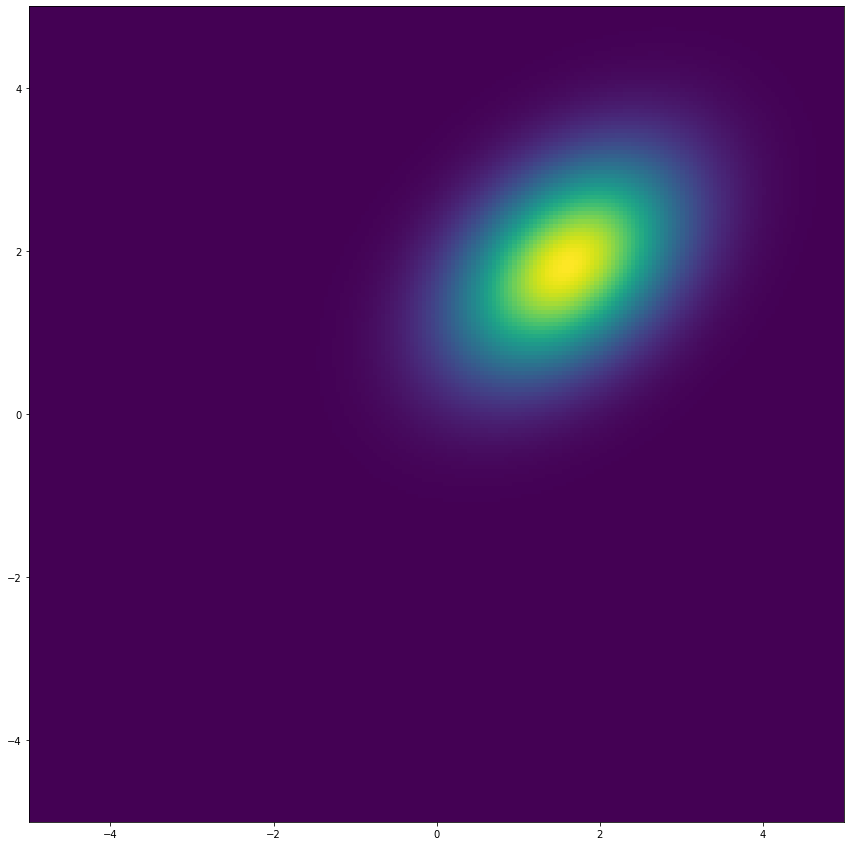

 97%|█████████▋| 38996/40000 [23:04<00:32, 30.75it/s]

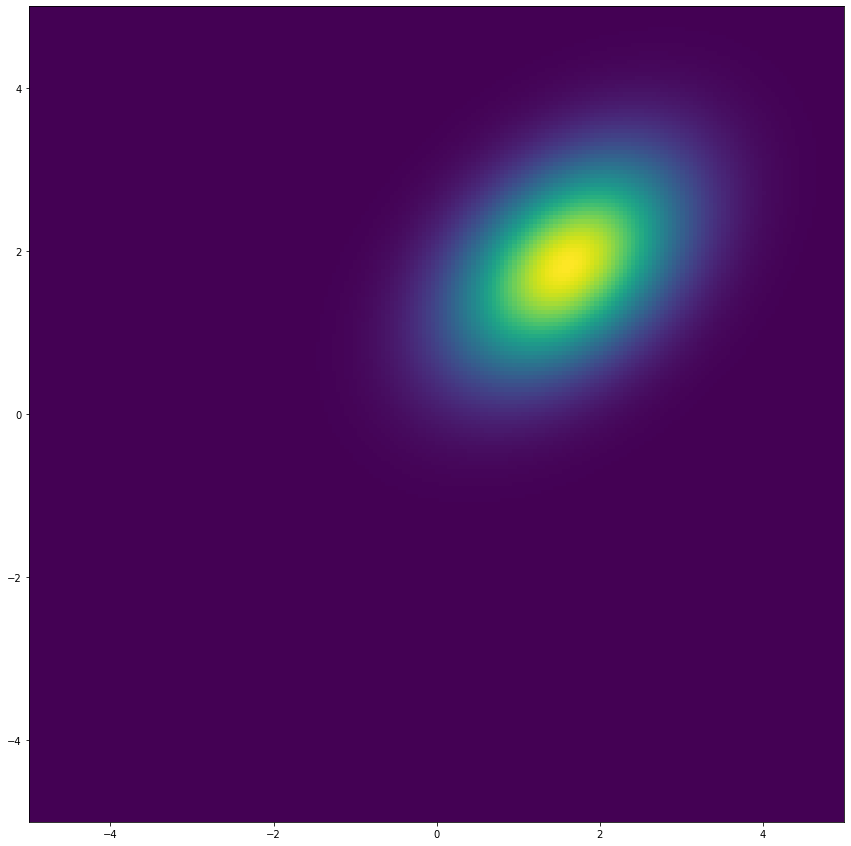

 99%|█████████▊| 39498/40000 [23:21<00:17, 28.33it/s]

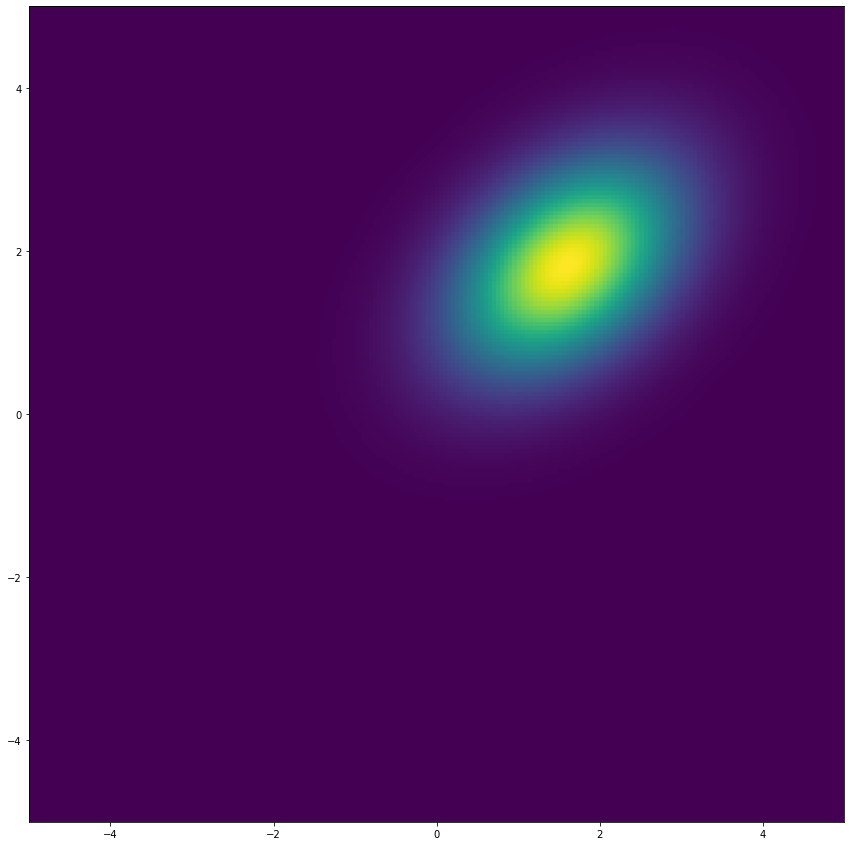

100%|█████████▉| 39997/40000 [23:38<00:00, 30.72it/s]

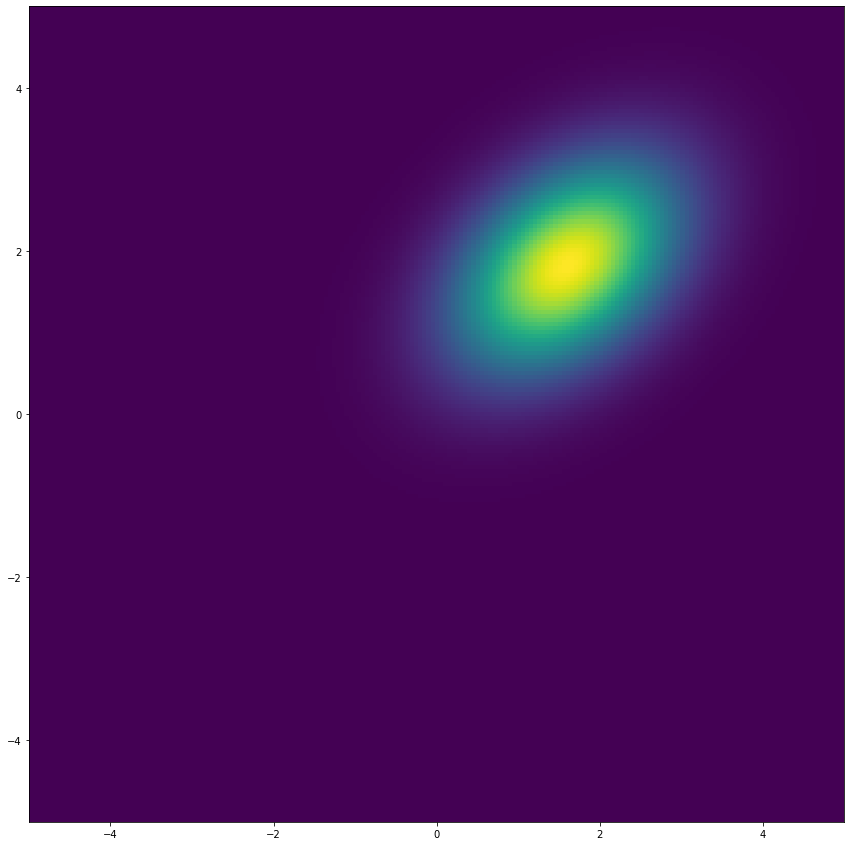

100%|██████████| 40000/40000 [23:38<00:00, 28.19it/s]


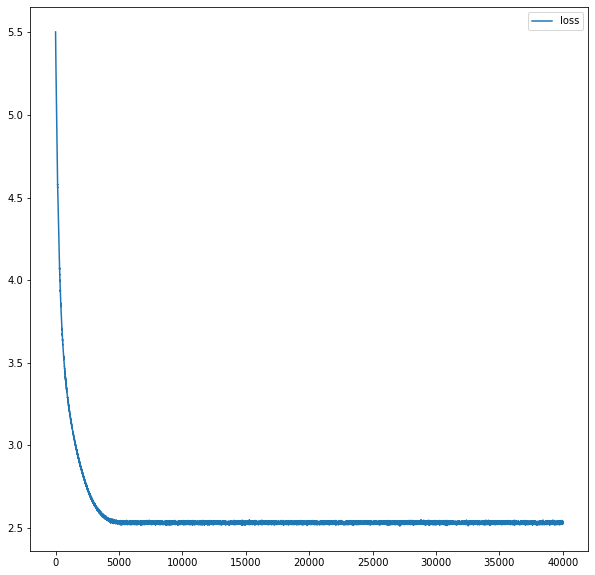

In [128]:
# Train model
max_iter = 40000
num_samples = 2 ** 9
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    x_np = nu.forward(100000)[0].numpy()
    x = torch.tensor(x_np).float()
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned posterior
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [129]:
list(model.parameters())

[Parameter containing:
 tensor([[1.3979, 1.3757]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1174, -0.1873]], requires_grad=True),
 Parameter containing:
 tensor(0.3038, requires_grad=True),
 Parameter containing:
 tensor(0.0981, requires_grad=True)]

In [130]:
import torchinfo

## Utils - scaling block

In [1]:
from utils import *

In [11]:
sb = ScalingBlock(2)
K_intervals = torch.Tensor([[0.5, 1],
                        [3,3]])
nu = NormUnif(2, 0.8, K_intervals=K_intervals)
x = nu.forward(10)

In [12]:
t_float = 0.3
t = torch.tensor(t_float)
true_prob = nu.prob_greater_t(t).item()
print(true_prob)
type(true_prob)

0.3167933225631714


float